# Machine Learning Wikipedia article classification

This project aims to better understand information content offered by Wikipedia and develop an automatic multi-class text classification system that allows to effectively categorize published articles, using the PySpark's Machine Learning Library (MLib). Specifically, an exploratory data analysis will be first conducted to understand the characteristics of Wikipedia content, divided into different thematic categories, and, subsequently, a machine learning model will be trained and evaluated to classify articles based on their category.

The project will be based on a dataset containing about 150,000 Wikipedia articles, associated with one of 15 categories, including Culture, Economics, Medicine, Technology, Politics, Science and others.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (col, count, lit, desc, concat_ws, size, explode, lower, length, array_size,
                                   sum as sp_sum, avg as sp_avg, min as sp_min, max as sp_max)
from pyspark.ml.feature import (Tokenizer, StopWordsRemover, CountVectorizer, IDF, StandardScaler, StringIndexer,
                                IndexToString)
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel, NaiveBayes, NaiveBayesModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import (precision_recall_fscore_support, roc_auc_score, average_precision_score,
                             confusion_matrix, roc_curve, precision_recall_curve)
from sklearn.preprocessing import label_binarize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
# Setting some parameters for matplotlib figures
plt.rcParams["figure.dpi"] = 240
sns.set_theme()

In [ ]:
# Create directory and download the original dataset
!mkdir -p /content/drive/MyDrive/Volumes/my_catalog/raw/datasets
!curl -L "https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv" \
  -o /content/drive/MyDrive/Volumes/my_catalog/raw/datasets/wikipedia.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  956M  100  956M    0     0  13.5M      0  0:01:10  0:01:10 --:--:-- 14.5M


In [4]:
# Initialize a Spark session
spark = SparkSession.builder.appName("Big Data Project").getOrCreate()

In [5]:
# Load the dataset
path = "/content/drive/MyDrive/Volumes/my_catalog/raw/datasets/wikipedia.csv"
df = spark.read.csv(path, header=True, inferSchema=True, quote='"', escape='"')
df = df.withColumnRenamed("categoria", "category")

## 1) Exploratory data analysis

First, an exploration of the dataset is peformed to analyse the characteristics of the text data and obtain useful information for the classification process.

### Dataset overview

In [6]:
# Dataset size, structure and visualization of first 5 rows
print(f"Dataset size: {df.count()} rows")
df.printSchema()
df.show(5)

Dataset size: 153232 rows
root
 |-- _c0: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- documents: string (nullable = true)
 |-- category: string (nullable = true)

+---+--------------------+--------------------+--------------------+---------+
|_c0|               title|             summary|           documents| category|
+---+--------------------+--------------------+--------------------+---------+
|  0|           economics|economics () is a...|economics () is a...|economics|
|  1|index of economic...|this aims to be a...|this aims to be a...|economics|
|  2|     cryptoeconomics|cryptoeconomics i...|cryptoeconomics i...|economics|
|  3|economic impact a...|an economic impac...|an economic impac...|economics|
|  4|      economic trend|economic trend ma...|economic trend ma...|economics|
+---+--------------------+--------------------+--------------------+---------+
only showing top 5 rows



In [7]:
# Count of null values per column

columns = ["title", "summary", "documents", "category"]

null_counts = df.select([sp_sum(col(c).isNull().cast("int")).alias(c) for c in columns]) \
              .collect()[0]

print("Null values per column:")
for c in columns:
    print(f"  {c}: {null_counts[c]}")

Null values per column:
  title: 0
  summary: 928
  documents: 928
  category: 0


Since null values are found across some essential columns, the correspnding rows are removed from the dataset.

In [8]:
# Drop rows with null values
df = df.dropna(subset=columns)
print(f"Dataset size (no null): {df.count()} rows")

Dataset size (no null): 152304 rows


Duplicated rows acoross the same columns are also removed.

In [9]:
# Remove duplicates across "title", "summary", "documents" and "category"
df = df.dropDuplicates(columns)
print(f"Dataset size (no null/duplicates): {df.count()} rows")

Dataset size (no null/duplicates): 75523 rows


After removing rows with null values and duplicates, the dataset now contains about 75,000 articles.

### Category distribution

Here, the distribution of the different article categories in the dataset is analysed, calculating and visualizing the absolute and relative frequency of each category.

In [10]:
cat_counts = df.groupBy("category") \
             .agg(count(lit(1)).alias("article_count")) \
             .orderBy(desc("article_count"))

cat_counts.show()

+-----------+-------------+
|   category|article_count|
+-----------+-------------+
|   medicine|         8311|
|  transport|         7936|
|   research|         7573|
| technology|         6750|
|engineering|         6133|
| humanities|         5854|
|    finance|         5582|
|       pets|         4825|
|     energy|         4641|
|  economics|         4263|
|      trade|         3873|
|    science|         3724|
|     sports|         3640|
|    culture|         2175|
|   politics|          243|
+-----------+-------------+



In [ ]:
# Collect to Pandas dataframe for plotting and calculate article percentage per category
cat_counts_pd = cat_counts.toPandas()
cat_counts_pd['article_pct'] = cat_counts_pd['article_count'].div(cat_counts_pd['article_count'].sum()).mul(100)
cat_counts_pd

category  article_count  article_pct
0      medicine           8311    11.004595
1     transport           7936    10.508057
2      research           7573    10.027409
3    technology           6750     8.937675
4   engineering           6133     8.120705
5    humanities           5854     7.751281
6       finance           5582     7.391126
7          pets           4825     6.388782
8        energy           4641     6.145148
9     economics           4263     5.644638
10        trade           3873     5.128239
11      science           3724     4.930948
12       sports           3640     4.819724
13      culture           2175     2.879917
14     politics            243     0.321756

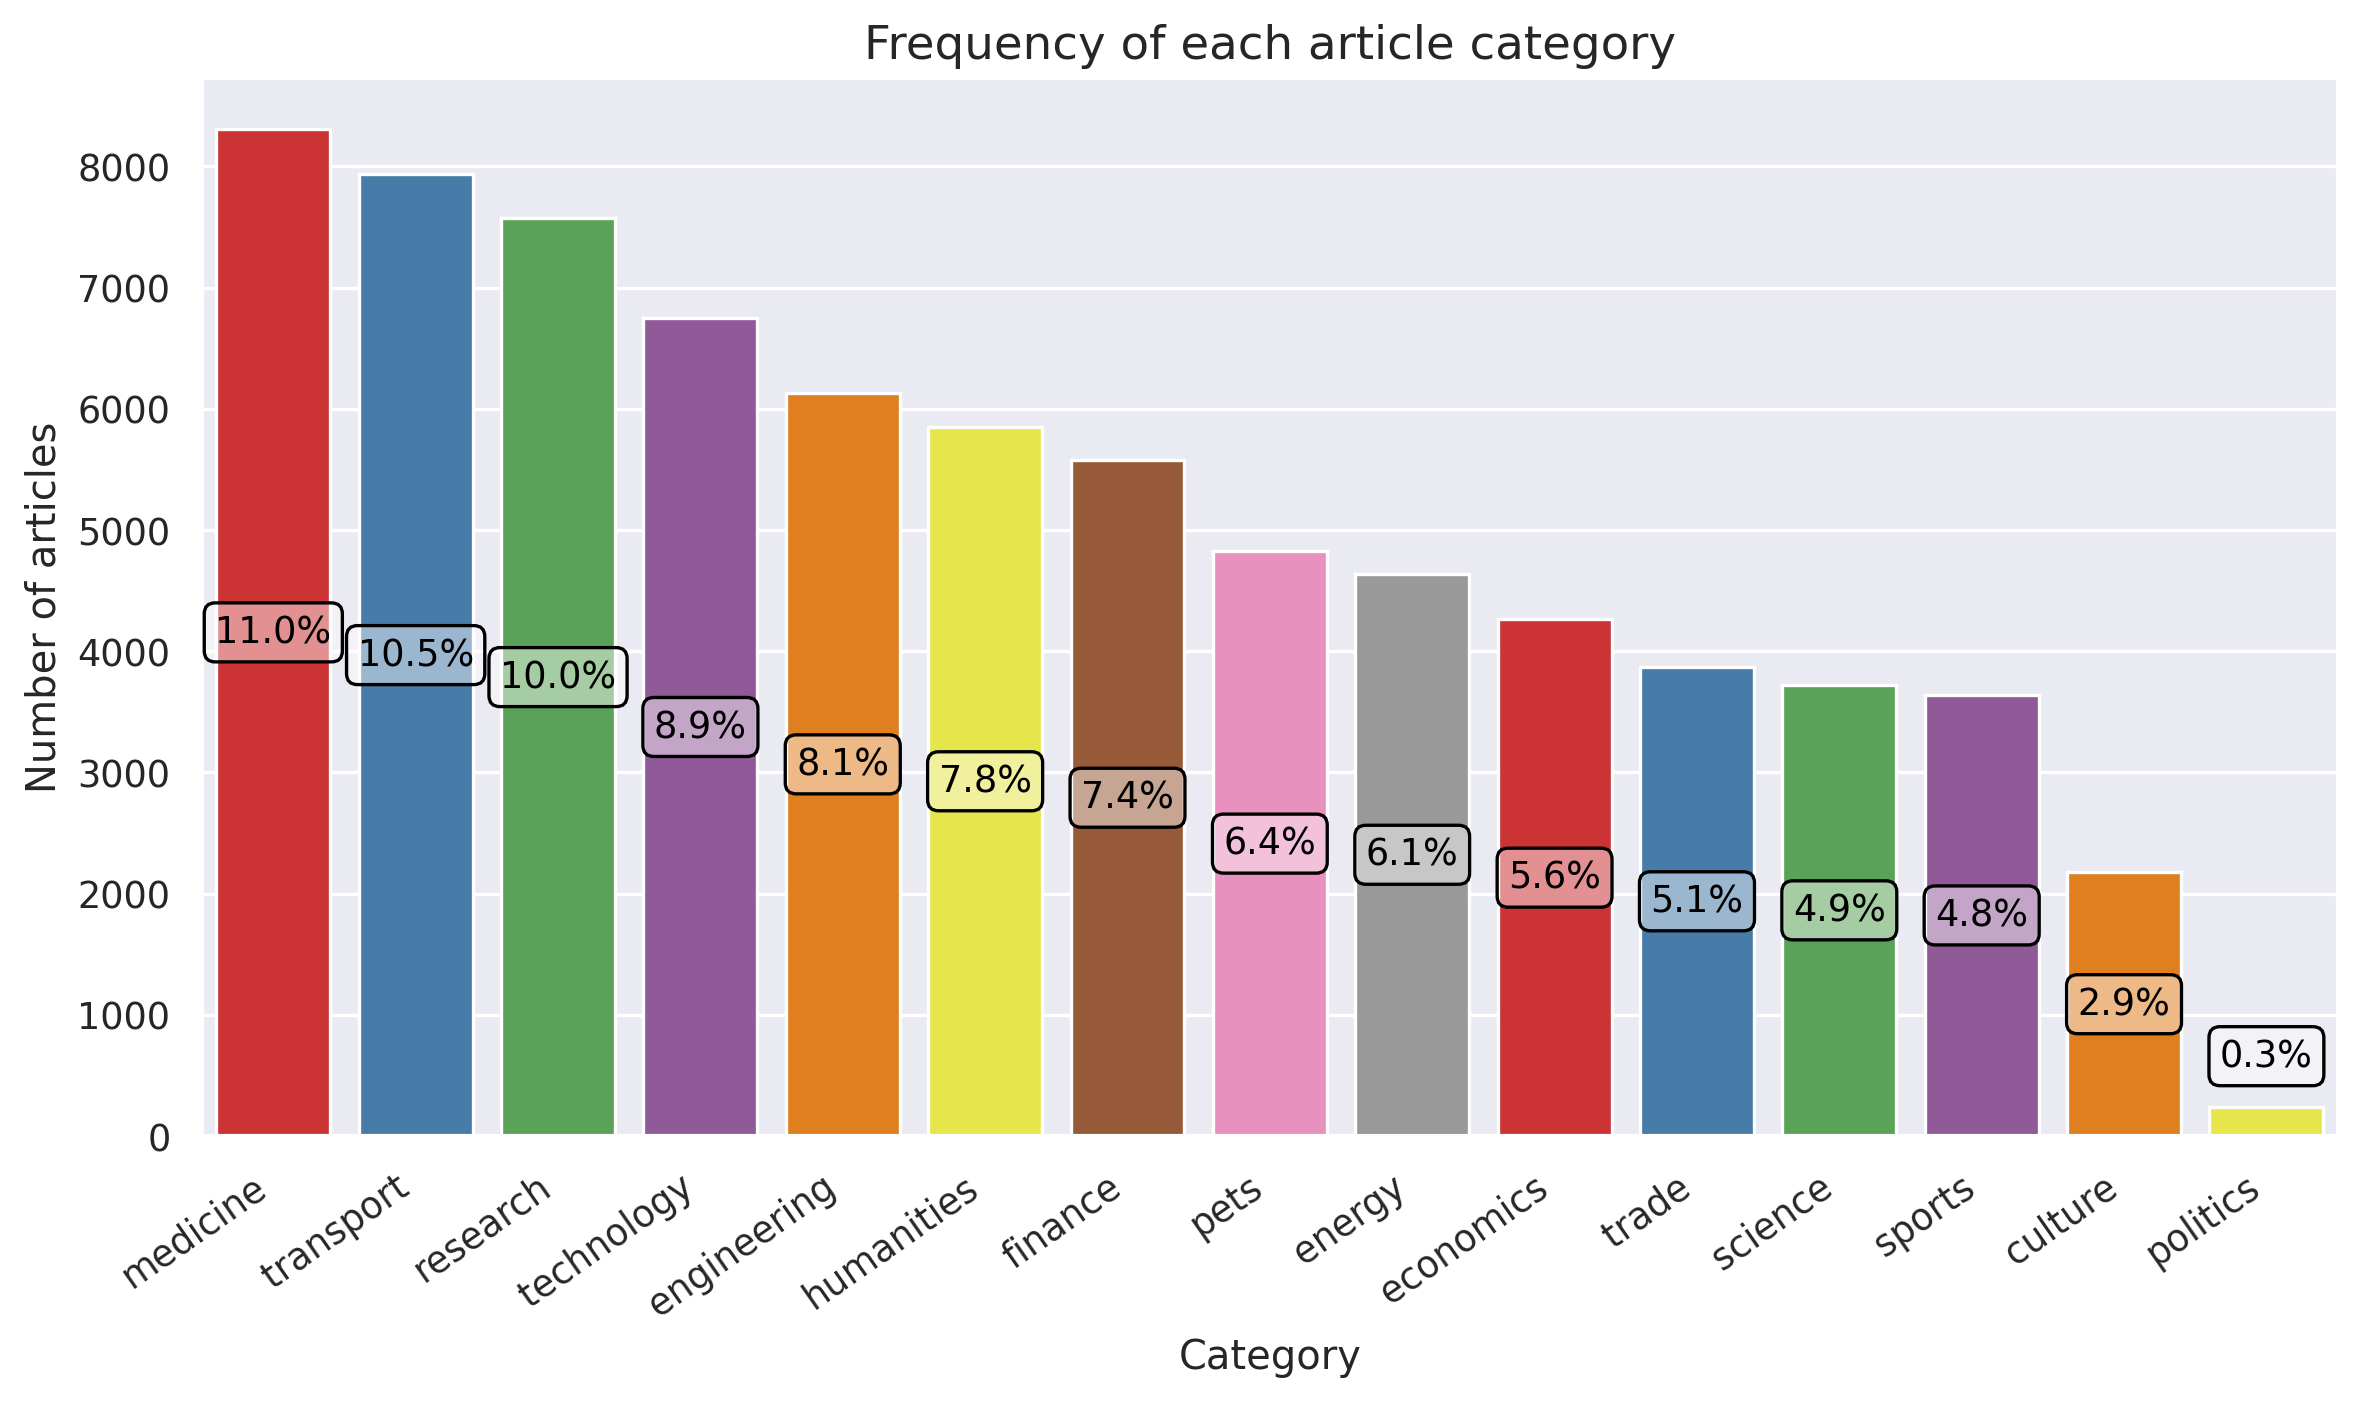

In [ ]:
# Bar plot of article categories
plt.figure(figsize=(10,6))

bars = sns.barplot(x=cat_counts_pd["category"], y=cat_counts_pd["article_count"], hue=cat_counts_pd["category"], palette="Set1")

bar_max = cat_counts_pd["article_count"].max()

for bar, pct in zip(bars.patches, cat_counts_pd['article_pct']):
    bars.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height()/2 if bar.get_height()/2 > bar_max*.1 else bar.get_height() + 0.05 * bar_max,
        f'{pct:.1f}%',
        ha="center", va="center",
        fontsize=11, color="black",
        bbox = dict(boxstyle="round", ec='black', fc="#ffffff75"))

plt.xlabel("Category")
plt.ylabel("Number of articles")
plt.title("Frequency of each article category", fontsize=14)
plt.xticks(rotation=35, ha='right')
plt.tight_layout()
plt.show()

It can be observed that the distribution of articles among the different categories is not perfectly balanced. Specifically, some of the categories, such as "politics" and "culture", have a particularly low frequency, which can possibly results in lower performances in the classification task.

### Length analysis

Here, an analysis of article length (based on the number of words) is performed, both overall and by category, considering lenght distribution, average and extreme values.

In [11]:
# Apply a tokenizer to split the "documents" column by white spaces and obtain single words
tokenizer = Tokenizer(inputCol="documents", outputCol="words")
df = tokenizer.transform(df)

# Count number of words per article
df = df.withColumn("word_count", size(col("words")))

df.select("title", "documents", "category", "words", "word_count").show(5)

+------------------+--------------------+---------+--------------------+----------+
|             title|           documents| category|               words|word_count|
+------------------+--------------------+---------+--------------------+----------+
| david cooperrider|david cooperrider...|economics|[david, cooperrid...|      2019|
|     merton miller|merton howard mil...|economics|[merton, howard, ...|       664|
|richard mattessich|richard victor al...|economics|[richard, victor,...|       830|
|     jay nunamaker|jay f. nunamaker ...|economics|[jay, f., nunamak...|       509|
|     jacques drèze|jacques h. drèze ...|economics|[jacques, h., drè...|      5420|
+------------------+--------------------+---------+--------------------+----------+
only showing top 5 rows



In [12]:
# Collect to Pandas dataframe for plotting
df_word_count_pd = df.select("title", "category", "word_count").toPandas()
df_word_count_pd

title   category  \
0                                      david cooperrider  economics   
1                                          merton miller  economics   
2                                     richard mattessich  economics   
3                                          jay nunamaker  economics   
4                                          jacques drèze  economics   
...                                                  ...        ...   
75518                            charles brenton huggins   research   
75519                                      fiona stanley   research   
75520                  central cotton research institute   research   
75521  national university of computer and emerging s...   research   
75522                                             terena   research   

       word_count  
0            2019  
1             664  
2             830  
3             509  
4            5420  
...           ...  
75518         614  
75519        1191  
75520          75  
75521         924  
75522        1280  

[75523 rows x 3 columns]

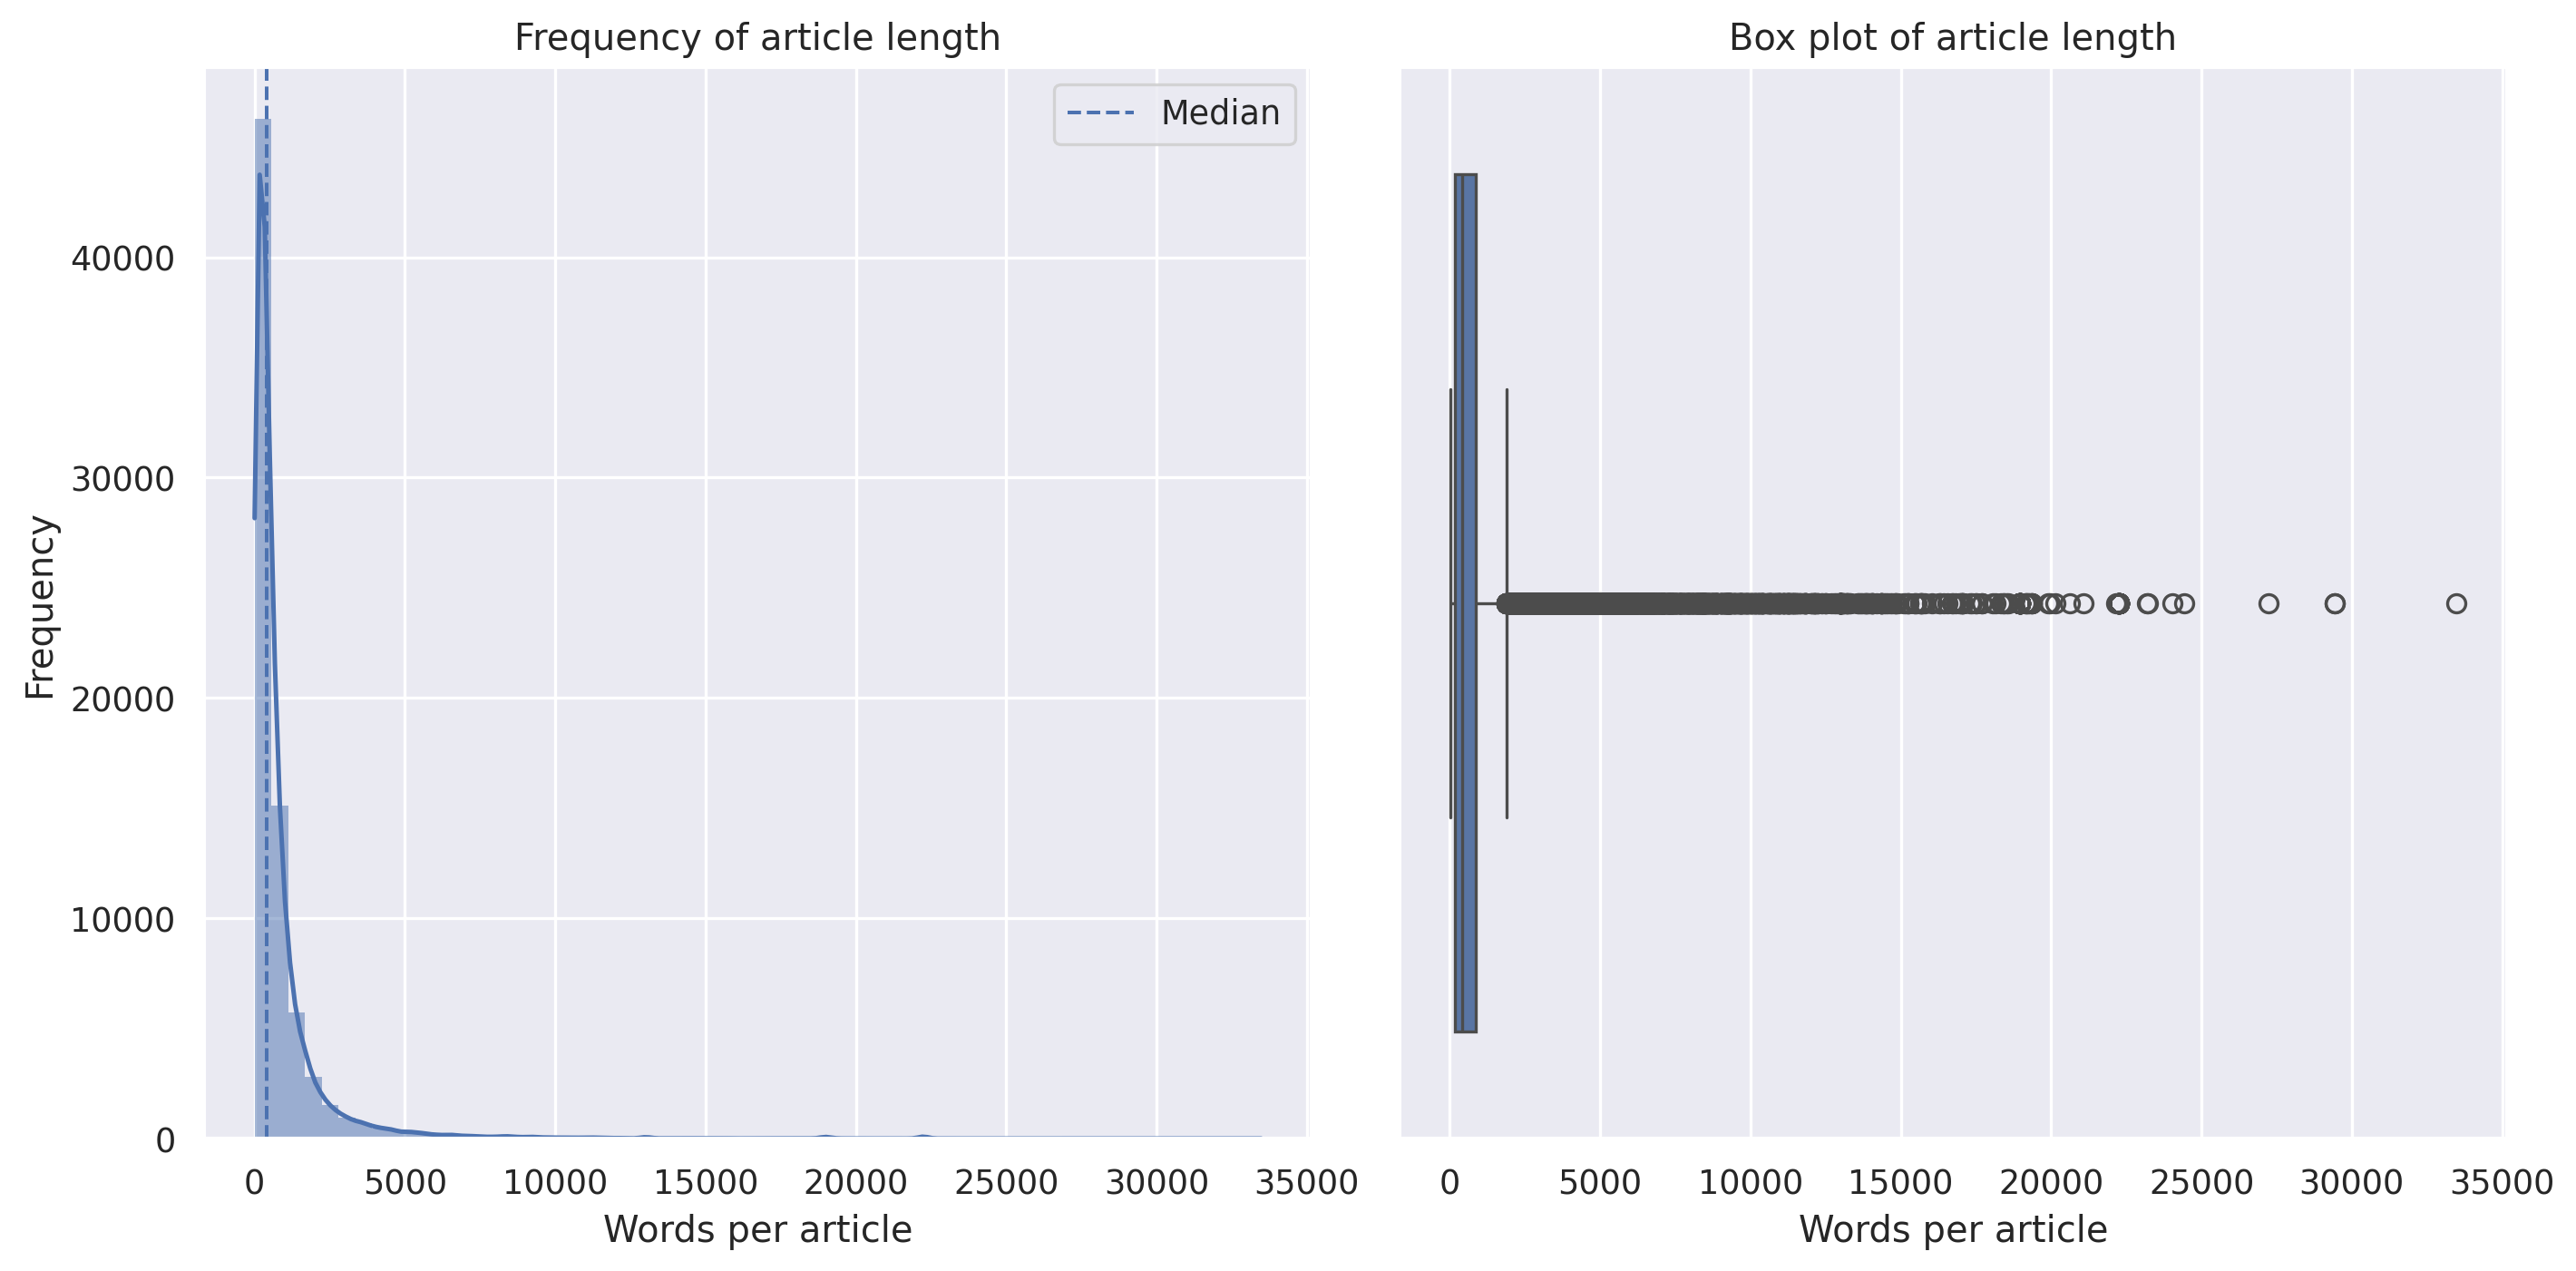

In [ ]:
# Overall length distribution

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
sns.histplot(df_word_count_pd['word_count'], bins=60, kde=True, edgecolor='none')
plt.axvline(df_word_count_pd['word_count'].median(), ls='--', lw=1.2, label='Median')
plt.xlabel("Words per article")
plt.ylabel("Frequency")
plt.title("Frequency of article length")
plt.legend()

plt.subplot(1, 2, 2)
bp = sns.boxplot(df_word_count_pd['word_count'], orient="y")
plt.xlabel("Words per article")
plt.title("Box plot of article length")

plt.tight_layout()
plt.show()

In [ ]:
# Overall average word count
overall_avg_wc = df.select(sp_avg(col("word_count")).alias("avg_words")).collect()[0]["avg_words"]
print(f"Overall average words per article: {overall_avg_wc:.2f}")

Overall average words per article: 836.75


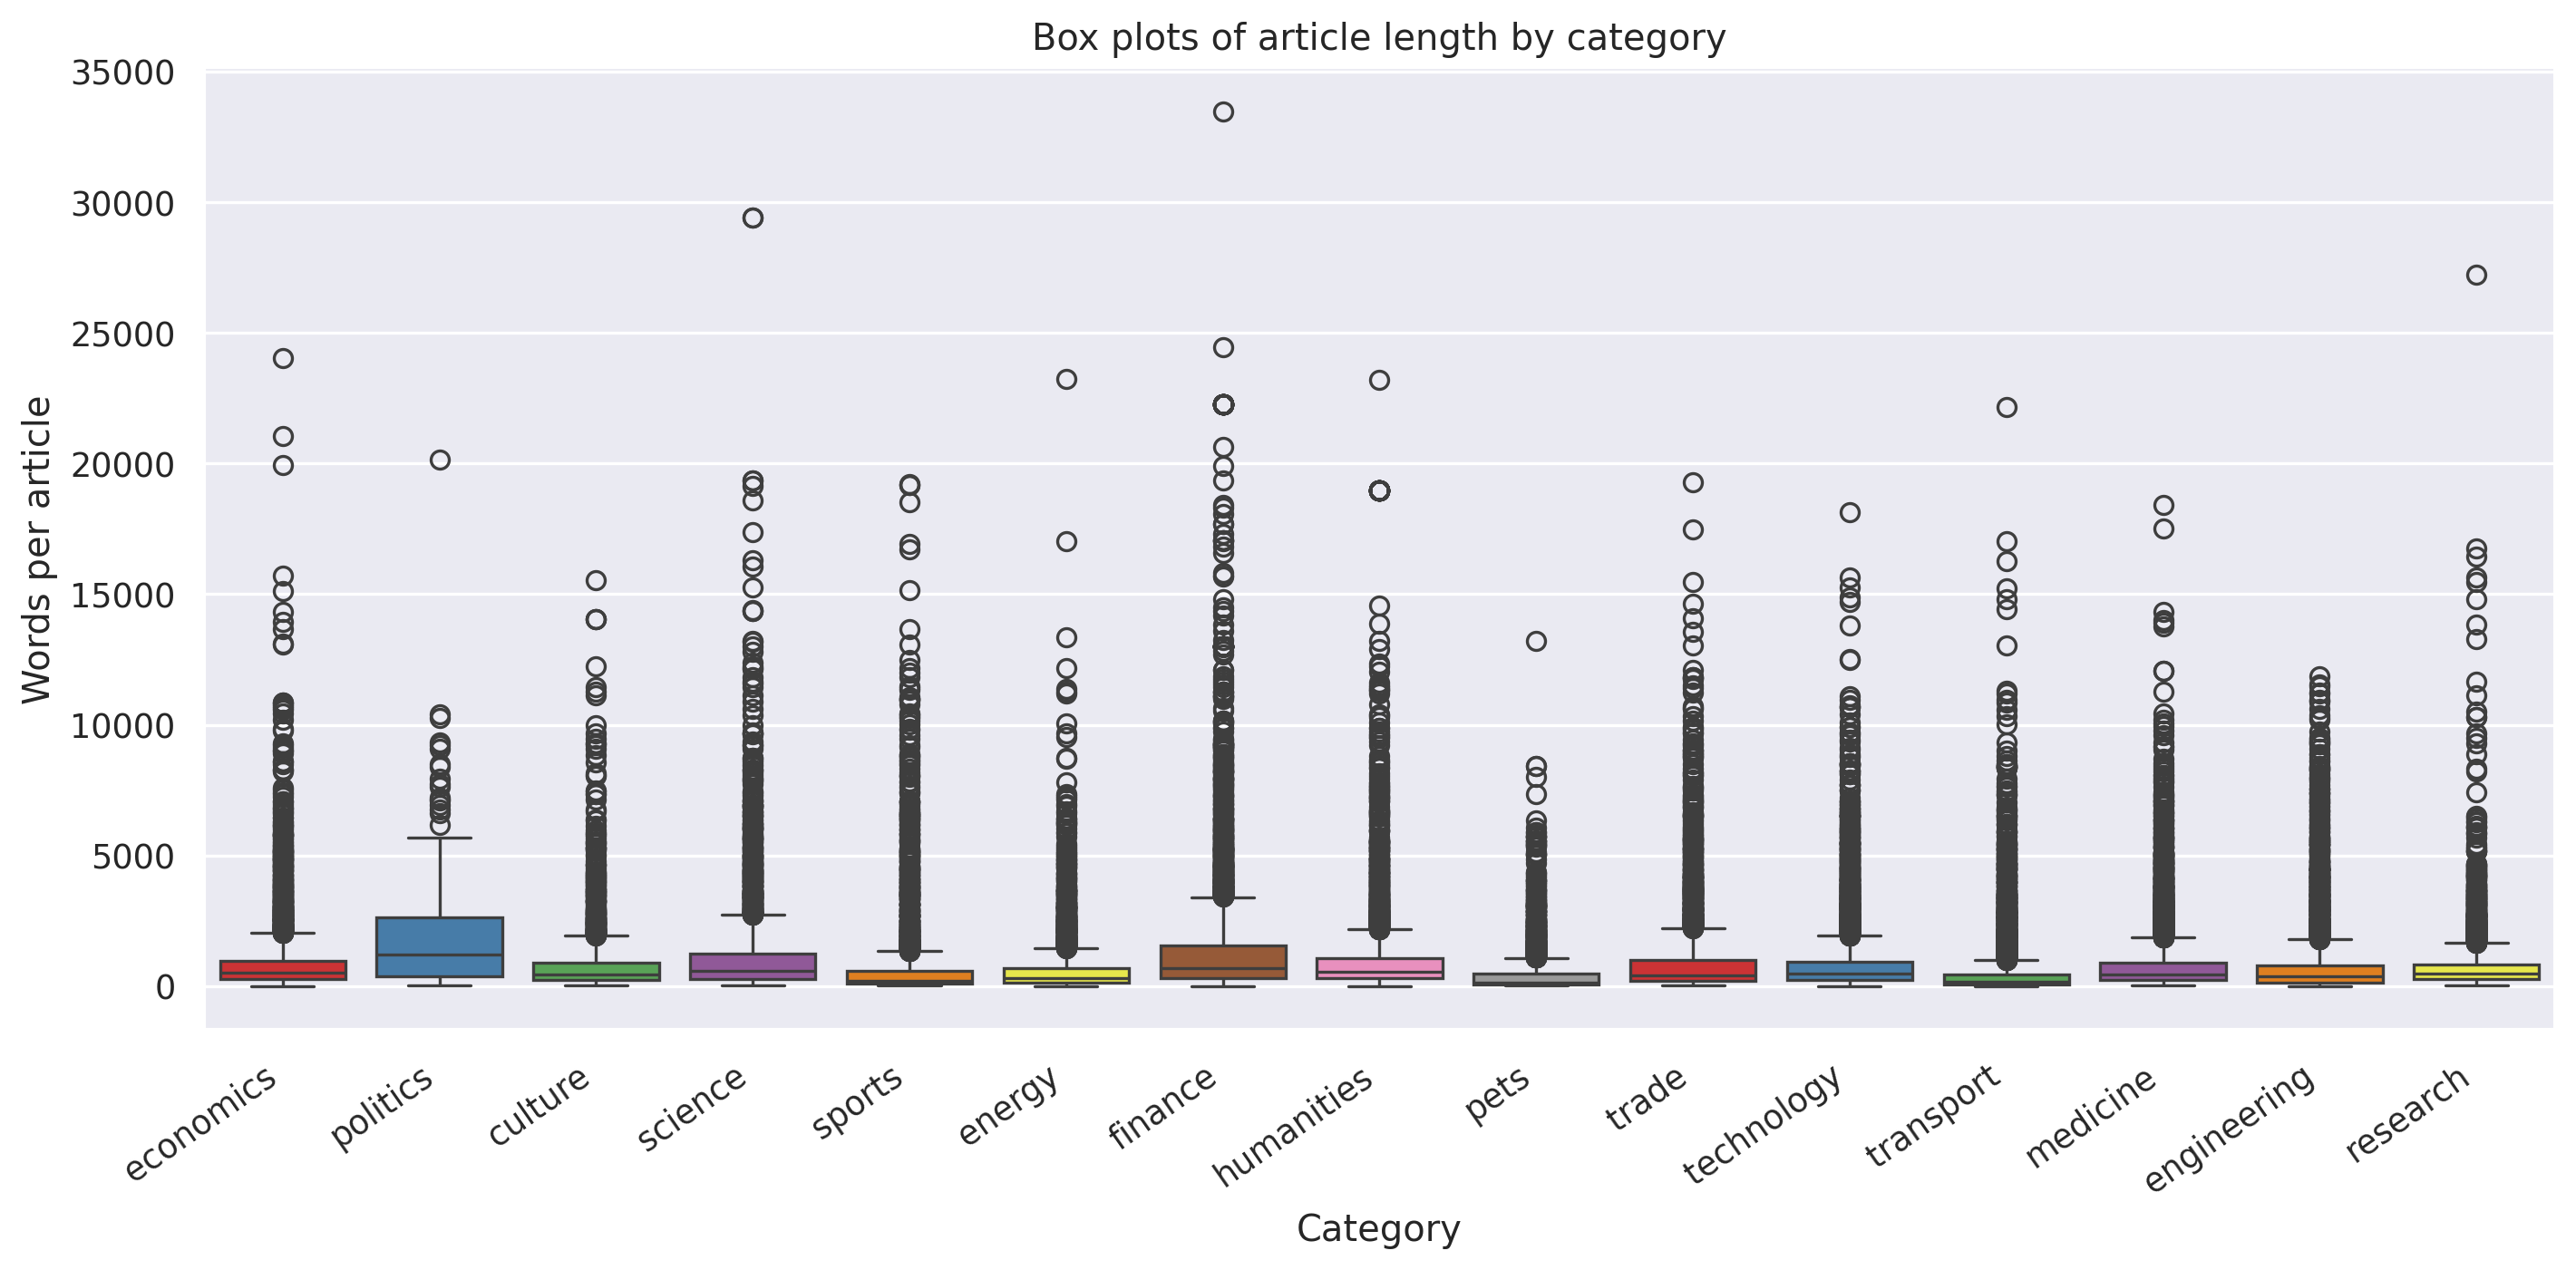

In [13]:
# Length distribution of articles by category
plt.figure(figsize=(12, 6))

sns.boxplot(data=df_word_count_pd, y='word_count', x='category', hue='category', palette="Set1", legend=False)
plt.xlabel("Category")
plt.ylabel("Words per article")

plt.title("Box plots of article length by category")
plt.xticks(rotation=35, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
# Average word count by category
cat_avg_wc = df.groupBy("category") \
    .agg(sp_avg(col("word_count")).alias("avg_words")) \
    .orderBy(desc("avg_words"))

cat_avg_wc.show()

+-----------+------------------+
|   category|         avg_words|
+-----------+------------------+
|   politics|2012.6954732510287|
|    finance| 1614.989251164457|
|    science|1148.3101503759399|
| humanities|1080.8361803894772|
|      trade| 949.4533953008004|
|  economics| 898.1020408163265|
| technology| 881.8402962962963|
|    culture| 867.5172413793103|
|   medicine| 777.2675971603899|
|engineering| 763.9059187999347|
|     sports| 762.1684065934066|
|   research| 691.6383203486068|
|     energy| 613.0603318250377|
|  transport| 470.7859122983871|
|       pets| 415.1075647668394|
+-----------+------------------+



In [ ]:
# Collect to Pandas dataframe for plotting
cat_avg_wc_pd = cat_avg_wc.toPandas()
cat_avg_wc_pd

category    avg_words
0      politics  2012.695473
1       finance  1614.989251
2       science  1148.310150
3    humanities  1080.836180
4         trade   949.453395
5     economics   898.102041
6    technology   881.840296
7       culture   867.517241
8      medicine   777.267597
9   engineering   763.905919
10       sports   762.168407
11     research   691.638320
12       energy   613.060332
13    transport   470.785912
14         pets   415.107565

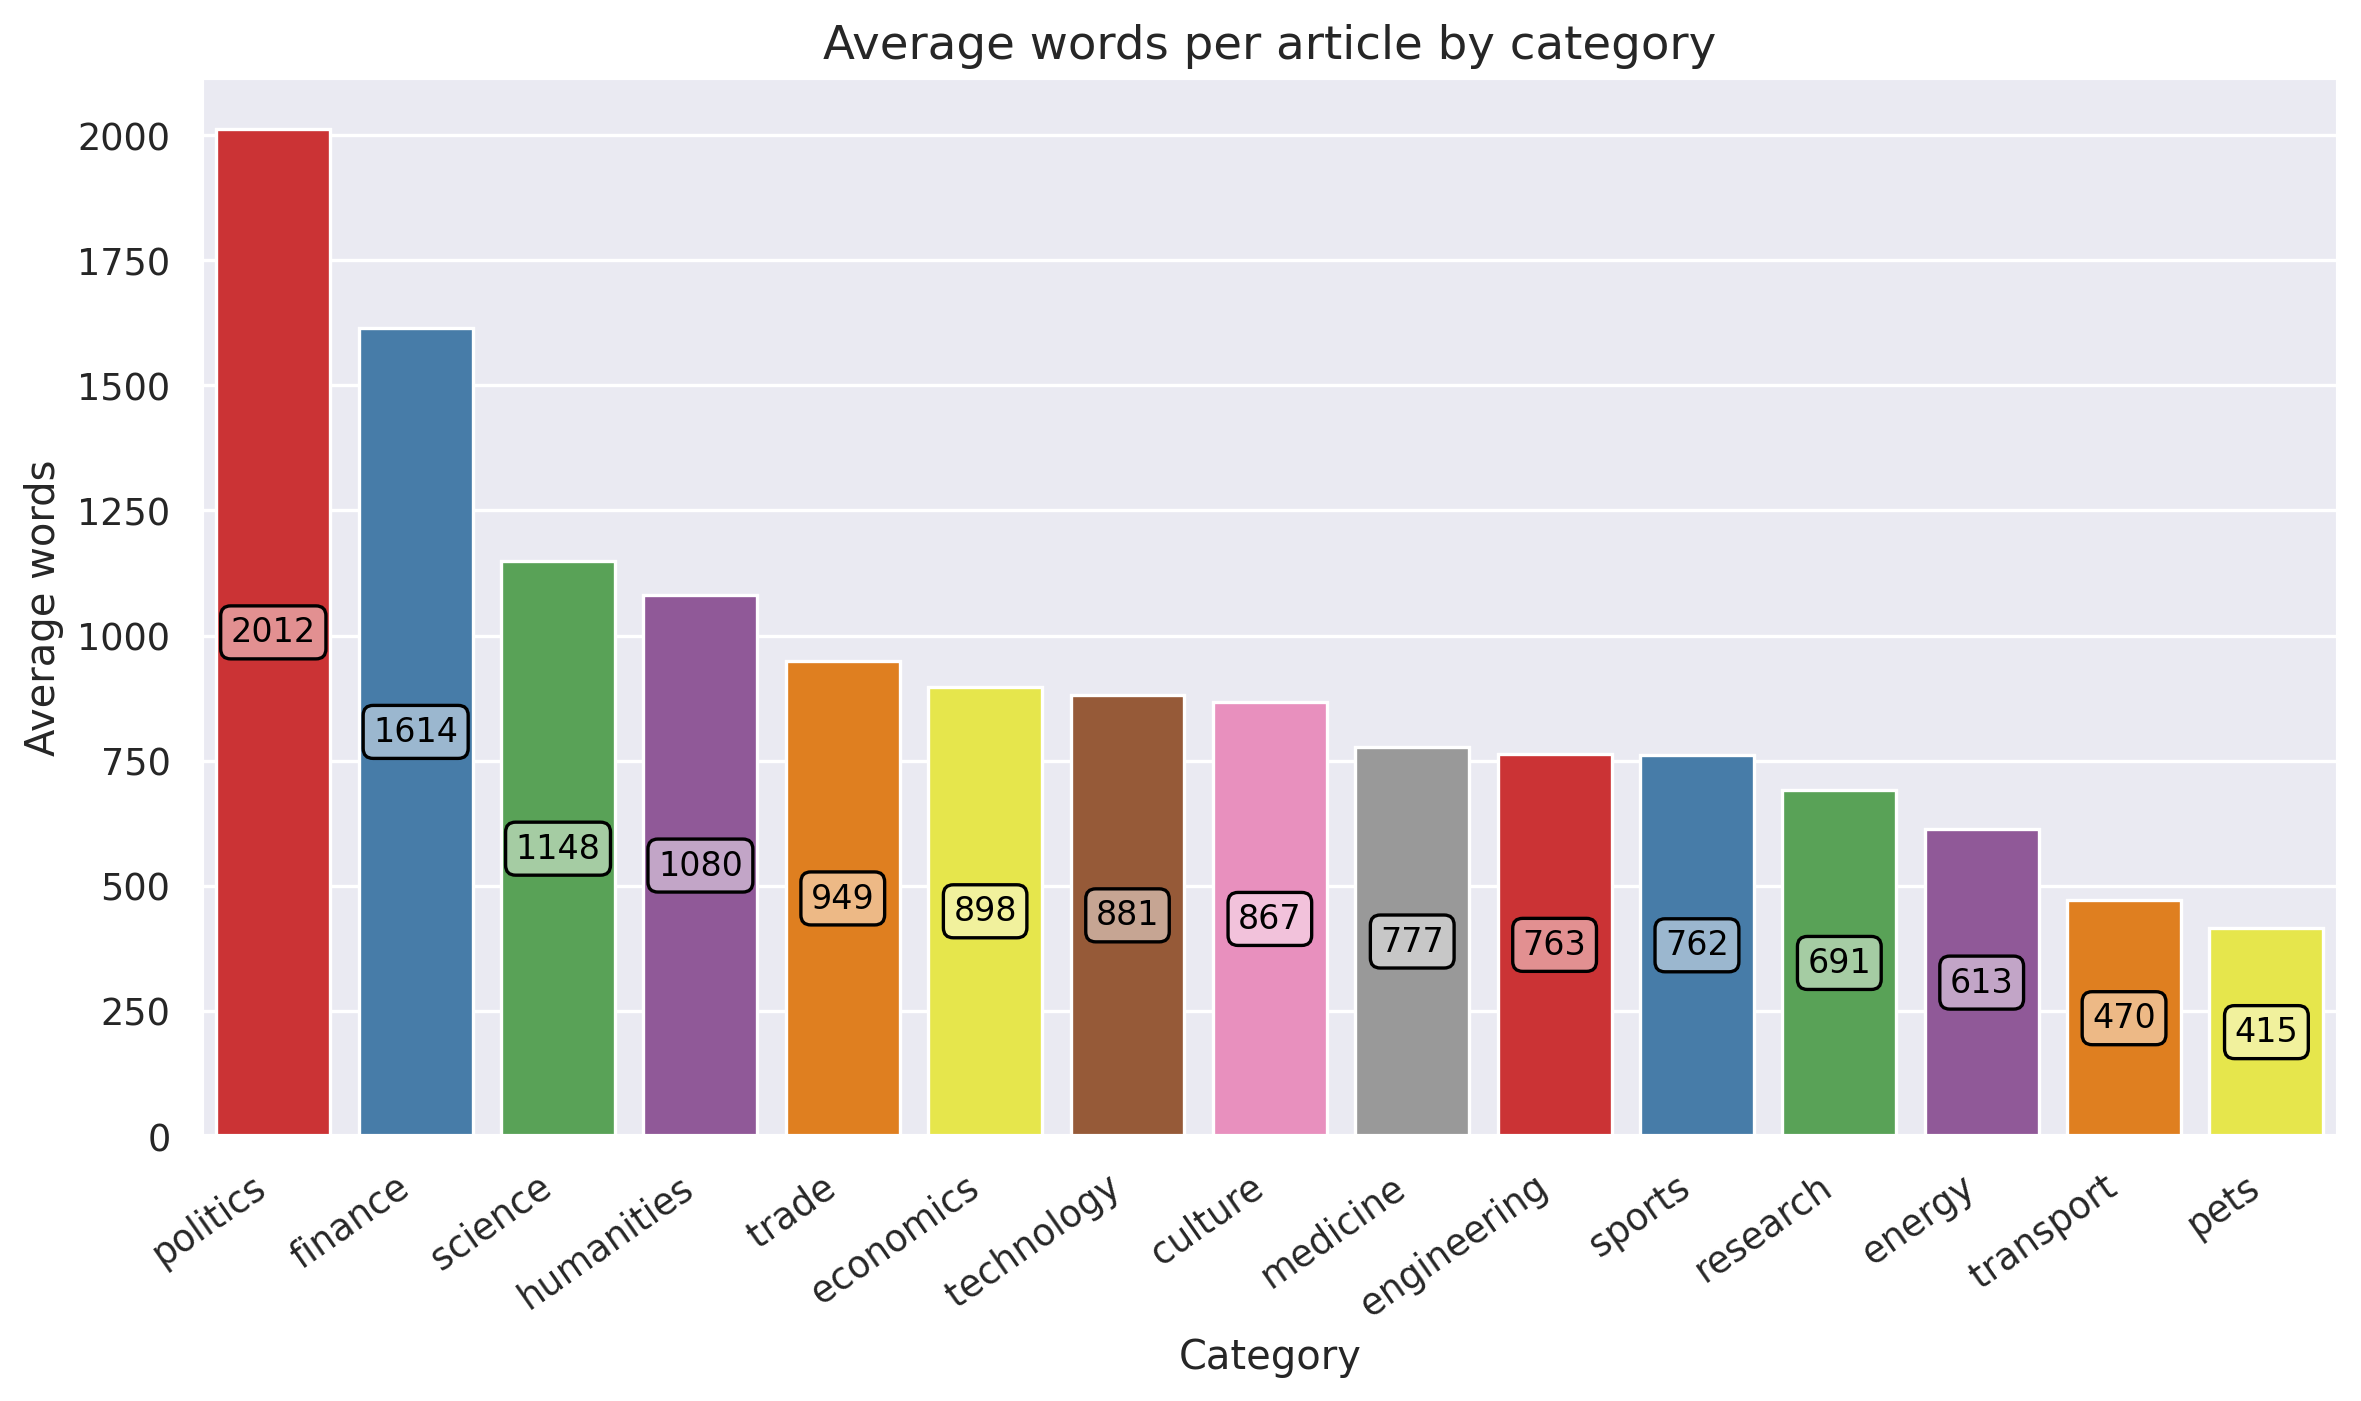

In [ ]:
# Bar plot of average article length by category
plt.figure(figsize=(10,6))
sns.barplot(x=cat_avg_wc_pd["category"], y=cat_avg_wc_pd["avg_words"], hue=cat_avg_wc_pd["category"], palette="Set1")
plt.xlabel("Category")
plt.ylabel("Average words")
plt.title("Average words per article by category", fontsize=14)
plt.xticks(rotation=35, ha='right')

for i, avg in enumerate(cat_avg_wc_pd["avg_words"]):
    plt.annotate(f"{int(avg)}",
                 xy=(i, avg/2),
                 ha='center', va='center',
                 fontsize=10, color='black',
                 bbox = dict(boxstyle="round", ec='black', fc="#ffffff75"))

plt.tight_layout()
plt.show()

In [ ]:
# Min/max word count by category
cat_minmax_wc = df.groupBy("category") \
                .agg(sp_min(col("word_count")).alias("min_words"),
                     sp_max(col("word_count")).alias("max_words")) \
                .orderBy("category")

cat_minmax_wc.show()

+-----------+---------+---------+
|   category|min_words|max_words|
+-----------+---------+---------+
|    culture|       11|    15538|
|  economics|       10|    24022|
|     energy|        9|    23223|
|engineering|        8|    11856|
|    finance|        3|    33479|
| humanities|        7|    23198|
|   medicine|       12|    18422|
|       pets|       12|    13222|
|   politics|       11|    20140|
|   research|       17|    27223|
|    science|       15|    29419|
|     sports|       14|    19227|
| technology|        2|    18144|
|      trade|       16|    19275|
|  transport|       10|    22150|
+-----------+---------+---------+



### Term frequency analysis

Here, the most frequent and relevant terms for each category are identified and visualized. Specifically, a count of token frequencies per category is performed, excluding english stop words, and the top 50 tokens per category are selected and used to generate word cloud images.

In [14]:
# Remove English stopwords from the "words" column
remover = StopWordsRemover(inputCol="words", outputCol="tokens_nostop")
df = remover.transform(df)

df.show(5)

+----+------------------+--------------------+--------------------+---------+--------------------+----------+--------------------+
| _c0|             title|             summary|           documents| category|               words|word_count|       tokens_nostop|
+----+------------------+--------------------+--------------------+---------+--------------------+----------+--------------------+
| 236| david cooperrider|david cooperrider...|david cooperrider...|economics|[david, cooperrid...|      2019|[david, cooperrid...|
| 379|     merton miller|merton howard mil...|merton howard mil...|economics|[merton, howard, ...|       664|[merton, howard, ...|
| 525|richard mattessich|richard victor al...|richard victor al...|economics|[richard, victor,...|       830|[richard, victor,...|
|1006|     jay nunamaker|jay f. nunamaker ...|jay f. nunamaker ...|economics|[jay, f., nunamak...|       509|[jay, f., nunamak...|
|1418|     jacques drèze|jacques h. drèze ...|jacques h. drèze ...|economics|[jacqu

In [15]:
# Explode tokens, lowercase and filter tokens of length > 2
tokens_long = df.select("category", "tokens_nostop") \
                .withColumn("token", explode(col("tokens_nostop"))) \
                .withColumn("token", lower(col("token"))) \
                .where(length(col("token")) > 2)

In [16]:
# Count tokens per category
token_freq = tokens_long.groupBy("category", "token") \
                        .agg(count(lit(1)).alias("cnt"))

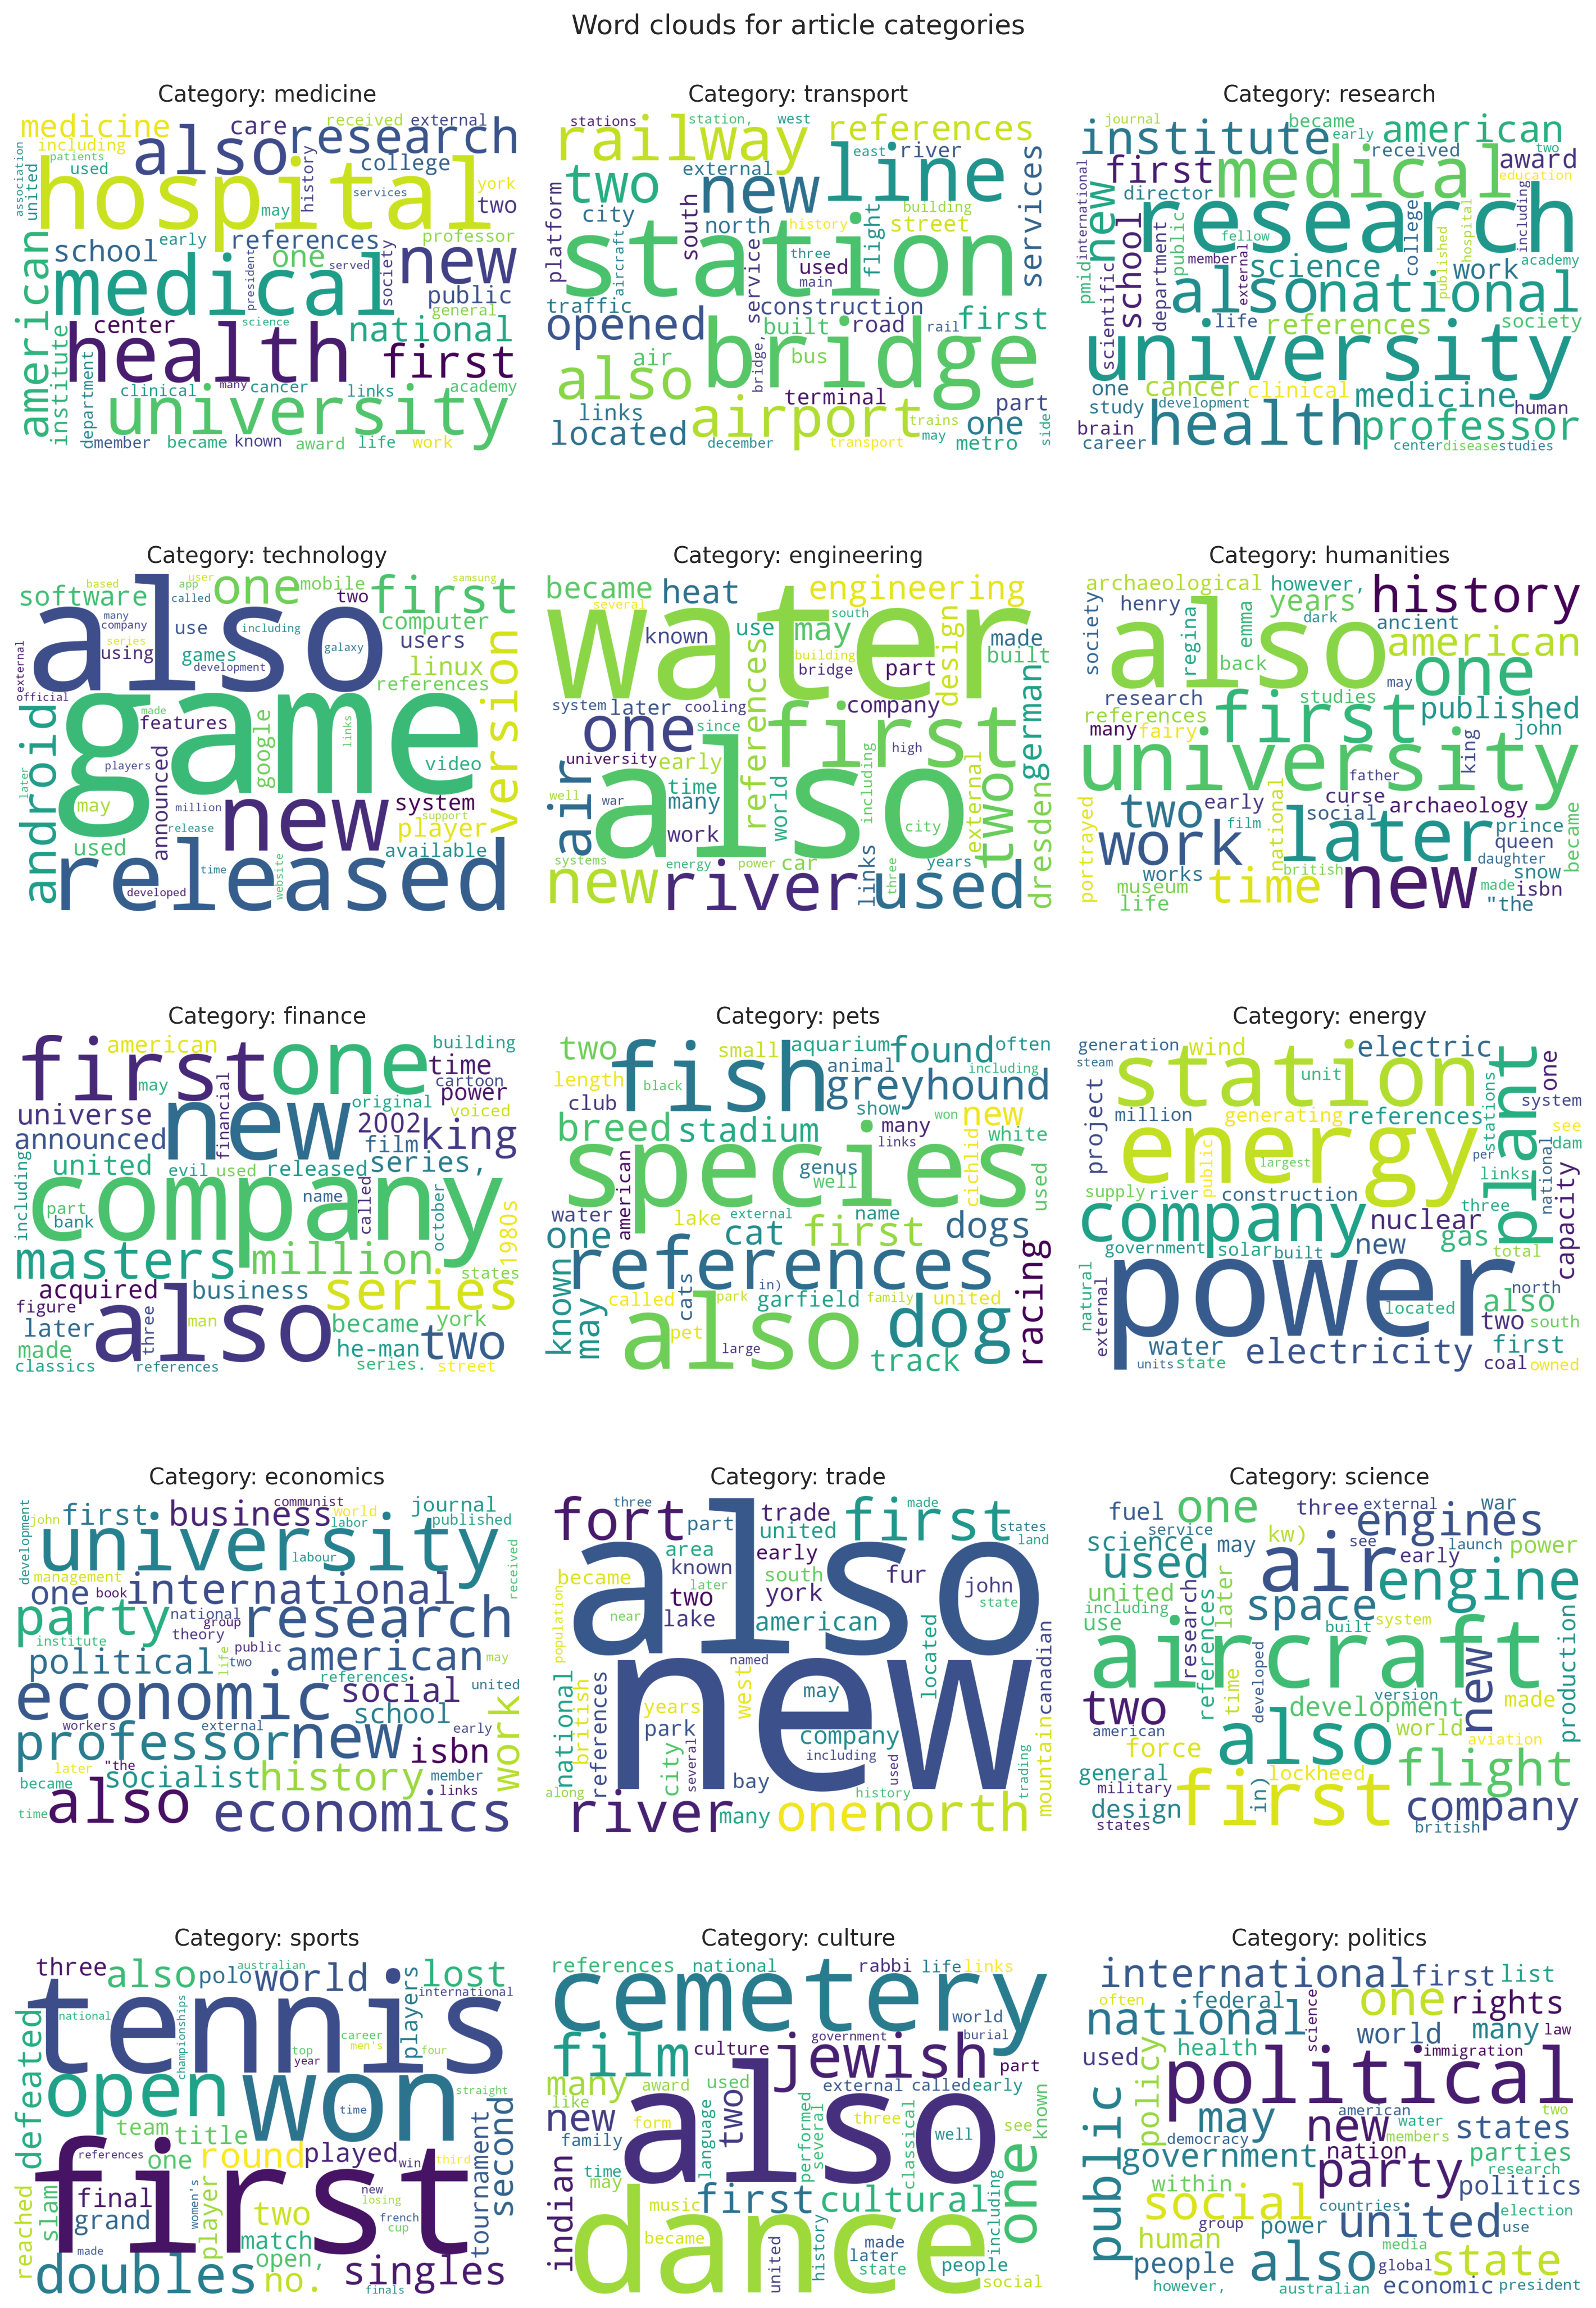

In [17]:
# For each category, take top N tokens by frequency, make a dictionary and generate word clouds

TOP_N = 50  # Tokens per category for the word cloud
categories = [r["category"] for r in cat_counts.select("category").collect()]

plt.figure(figsize=(12, 18))

for i, cat in enumerate(categories):

  # Select top N tokens
  top_tokens = token_freq.where(col("category") == lit(cat)) \
                         .orderBy(desc("cnt")) \
                         .limit(TOP_N) \
                         .select("token", "cnt") \
                         .toPandas()

  # Convert to frequency dictionary
  freqs = dict(zip(top_tokens["token"].tolist(), top_tokens["cnt"].tolist()))

  # Generate the word cloud
  wc = WordCloud(width=1200, height=800, background_color="white")
  wc.generate_from_frequencies(freqs)

  # Show as image
  plt.subplot(5, 3, i+1)
  plt.imshow(wc, interpolation="bilinear")
  plt.axis("off")
  plt.title(f"Category: {cat}", fontsize=12)

plt.suptitle("Word clouds for article categories")
plt.tight_layout()
plt.show()

## 2) Data preprocessing

In this phase, several cleaning and transformation methods are applied to the dataset in order to be properly processed by machine learning algorithms.

First, the "summary" and "documents" columns are concatenated to get a single text column, which will be used to train the classification model.

In [ ]:
# Combine summary and documents

df = df.withColumn(
    "text_all",
    concat_ws(" ", col("summary"), col("documents"))
)

df.show(5)

+----+------------------+--------------------+--------------------+---------+--------------------+----------+--------------------+--------------------+
| _c0|             title|             summary|           documents| category|               words|word_count|       tokens_nostop|            text_all|
+----+------------------+--------------------+--------------------+---------+--------------------+----------+--------------------+--------------------+
| 236| david cooperrider|david cooperrider...|david cooperrider...|economics|[david, cooperrid...|      2019|[david, cooperrid...|david cooperrider...|
| 379|     merton miller|merton howard mil...|merton howard mil...|economics|[merton, howard, ...|       664|[merton, howard, ...|merton howard mil...|
| 525|richard mattessich|richard victor al...|richard victor al...|economics|[richard, victor,...|       830|[richard, victor,...|richard victor al...|
|1006|     jay nunamaker|jay f. nunamaker ...|jay f. nunamaker ...|economics|[jay, f., n

### Stratified Train/Test split

Here, the dataset is split into train/test sets, preserving class proportions. This is obtained by applying a stratified sampling of the data based on a given fraction (80%) to obtain the train set. The remaing part of the original dataset is used as test set.

In [ ]:
# Build a dictionary with same fraction for each class

split_fraction = 0.8  # Train fraction per class
fractions = {r["category"]: split_fraction for r in cat_counts.collect()}
fractions

{'medicine': 0.8,
 'transport': 0.8,
 'research': 0.8,
 'technology': 0.8,
 'engineering': 0.8,
 'humanities': 0.8,
 'finance': 0.8,
 'pets': 0.8,
 'energy': 0.8,
 'economics': 0.8,
 'trade': 0.8,
 'science': 0.8,
 'sports': 0.8,
 'culture': 0.8,
 'politics': 0.8}

In [ ]:
# Get train set with stratified sampling (80% for each class)
train_df = df.sampleBy("category", fractions, seed=10)

# Subtract train data from original dataframe to get test set
test_df = df.subtract(train_df)

In [ ]:
print(f"Train dataset size: {train_df.count()}")
print("Train class distribution:")
train_df.groupBy("category").count().orderBy(desc("count")).show()

print(f"\nTest dataset size: {test_df.count()}")
print("Test class distribution:")
test_df.groupBy("category").count().orderBy(desc("count")).show()

Train dataset size: 60484
Train class distribution:
+-----------+-----+
|   category|count|
+-----------+-----+
|   medicine| 6651|
|  transport| 6333|
|   research| 6078|
| technology| 5410|
|engineering| 4941|
| humanities| 4682|
|    finance| 4469|
|       pets| 3818|
|     energy| 3742|
|  economics| 3377|
|      trade| 3110|
|    science| 3001|
|     sports| 2930|
|    culture| 1741|
|   politics|  201|
+-----------+-----+


Test dataset size: 15039
Test class distribution:
+-----------+-----+
|   category|count|
+-----------+-----+
|   medicine| 1660|
|  transport| 1603|
|   research| 1495|
| technology| 1340|
|engineering| 1192|
| humanities| 1172|
|    finance| 1113|
|       pets| 1007|
|     energy|  899|
|  economics|  886|
|      trade|  763|
|    science|  723|
|     sports|  710|
|    culture|  434|
|   politics|   42|
+-----------+-----+



### Vectorization and Label Encoding

In this section, a full preprocessing pipeline is defined, using PySpark feature transformers. The pipeline will be used to apply the following transformations to train and test data:
- tokenization ([Tokenizer](https://https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.Tokenizer.html)): input strings are converted to lowercase and split by white spaces, resulting in lists of tokens;
- stopwords removal ([StopWordsRemover](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StopWordsRemover.html)): stop words are filtered out from input tokens, since they are assumed to be not informative for the analysis;
- generation of frequency vectors ([CountVectorizer](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.CountVectorizer.html)): tokens are converted to vectors of term frequencies; the specified size of the vocabulary determines the number of features in the final dataset;
- scaling of vectors with Inverse document frequency ([IDF](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.feature.IDF.html)): feature vectors are weighted based on their frequency in the document and the entire corpus;
- standardization ([StandardScaler](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StandardScaler.html)): features are scaled to unit variance using column summary statistics;
- label encoding ([StringIndexer](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StringIndexer.html)): the string column of labels (“category”) is encoded to a column of label indices.

In [ ]:
def preprocess_data(train_df, test_df, num_features):

  # Split the "text_all" column by white spaces
  tokenizer = Tokenizer(inputCol="text_all", outputCol="tokens_all")

  # Remove English stopwords
  remover = StopWordsRemover(inputCol="tokens_all", outputCol="tokens_all_nostop")

  # Generate the term frequency vectors using CountVectorizer
  freq_vectors = CountVectorizer(inputCol="tokens_all_nostop", outputCol="tf_vectors", vocabSize=num_features)

  # Scale frequency vectors using IDF
  idf = IDF(inputCol="tf_vectors", outputCol="tfidf_vectors")

  # Standardize features to unit variance
  scaler = StandardScaler(inputCol="tfidf_vectors", outputCol="features")

  # Encode the string "category" column to a column of category indices
  indexer = StringIndexer(inputCol="category", outputCol="category_index")

  # Build pipeline
  preprocess_pipeline = Pipeline(stages=[tokenizer, remover, freq_vectors, idf, scaler, indexer])

  # Fit on training set
  preprocess_model = preprocess_pipeline.fit(train_df)

  # Transform train and test
  train_df_prep = preprocess_model.transform(train_df)
  test_df_prep  = preprocess_model.transform(test_df)

  # Keep only relevant columns
  cols_to_keep = ["title", "features", "category", "category_index"]
  train_df_prep = train_df_prep.select(*cols_to_keep)
  test_df_prep  = test_df_prep.select(*cols_to_keep)

  return train_df_prep, test_df_prep, preprocess_model

## 3) Classification Model training

In this section, two machine learning models will be trained to classify article categories. For each model, some main evaluation metrics will be calculated after generating predictions on the test set.

### Logistic Regression

The first algorithm considered is [Logistic Regression](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegression.html), a linear model for classification where the probabilities that an input belongs to a specific class are modeled using a logistic function. For this model, input data in train and test sets will have 10,000 features.

In [ ]:
train_df_lr, test_df_lr, preprocess_model_lr = preprocess_data(train_df, test_df, num_features = 10000)

In [ ]:
# Show train set features
print("Train dataset size:", train_df_lr.count())
train_df_lr.select("features", "category", "category_index").show(5, truncate=50)

Train dataset size: 60484
+--------------------------------------------------+---------+--------------+
|                                          features| category|category_index|
+--------------------------------------------------+---------+--------------+
|(10000,[0,1,2,3,4,5,6,7,9,11,13,14,16,17,19,22,...|economics|           9.0|
|(10000,[0,4,5,6,7,9,11,18,25,27,32,34,35,36,37,...|economics|           9.0|
|(10000,[0,1,2,3,4,5,6,7,9,11,14,15,17,18,22,23,...|economics|           9.0|
|(10000,[0,4,5,6,8,11,12,25,30,32,35,37,42,45,48...|economics|           9.0|
|(10000,[1,4,11,12,18,20,23,37,41,43,48,52,69,85...|economics|           9.0|
+--------------------------------------------------+---------+--------------+
only showing top 5 rows



In [ ]:
# Show test set features
print("Test dataset size:", test_df_lr.count())
test_df_lr.select("features", "category", "category_index").show(5, truncate=50)

Test dataset size: 15039
+--------------------------------------------------+-----------+--------------+
|                                          features|   category|category_index|
+--------------------------------------------------+-----------+--------------+
|(10000,[0,1,6,7,11,32,35,39,69,72,75,88,112,116...|  economics|           9.0|
|(10000,[0,1,2,3,5,6,9,11,15,16,21,22,23,24,28,3...|   medicine|           0.0|
|(10000,[0,1,5,7,11,14,16,18,24,32,34,35,63,65,7...|engineering|           4.0|
|(10000,[10,11,20,50,85,114,248,357,1178,1247,13...|  transport|           1.0|
|(10000,[0,5,6,11,12,16,18,22,23,30,50,55,56,68,...|   research|           2.0|
+--------------------------------------------------+-----------+--------------+
only showing top 5 rows



In [ ]:
# Show label order from StringIndexer
indexer_model = [stg for stg in preprocess_model_lr.stages if hasattr(stg, "labels")][0]
label_names = indexer_model.labels
print("Indices and label:")
for i, lab in enumerate(label_names):
    print(f"{i}: {lab}")

Indices and label:
0: medicine
1: transport
2: research
3: technology
4: engineering
5: humanities
6: finance
7: pets
8: energy
9: economics
10: trade
11: science
12: sports
13: culture
14: politics


In [ ]:
# Train Logistic Regression model with preprocessed train dataset

lr = LogisticRegression(
    featuresCol="features",
    labelCol="category_index",
    predictionCol="prediction",
    probabilityCol="probability",
    rawPredictionCol="rawPrediction",
    maxIter=20,
    family="multinomial"
)

lr_model = lr.fit(train_df_lr)

In [ ]:
# Generate predictions on test dataset
lr_preds = lr_model.transform(test_df_lr)

In [ ]:
# Map prediction indices to label names
idx_to_str = IndexToString(inputCol="prediction", outputCol="predicted_label", labels=label_names)
lr_preds = idx_to_str.transform(lr_preds)

In [ ]:
# Preview predictions
lr_preds.select("title", "category_index", "category", "prediction", "predicted_label").show(20, truncate=50)

+---------------------------------------------+--------------+-----------+----------+---------------+
|                                        title|category_index|   category|prediction|predicted_label|
+---------------------------------------------+--------------+-----------+----------+---------------+
|                                jeanne harris|           9.0|  economics|       9.0|      economics|
|                          mayo clinic florida|           0.0|   medicine|       0.0|       medicine|
|                        dresden green diamond|           4.0|engineering|       4.0|    engineering|
|                         xiangyulubei station|           1.0|  transport|       1.0|      transport|
|                                operation dew|           2.0|   research|       8.0|         energy|
|                   charles p. de saint-aignan|           3.0| technology|       3.0|     technology|
|    2004 us open – women's singles qualifying|          12.0|     sports|      12

In [ ]:
# Calculate main metrics
lr_metrics = {}
for metric in ["accuracy", "f1", "weightedPrecision", "weightedRecall"]:
    evaluator = MulticlassClassificationEvaluator(
        labelCol="category_index",
        predictionCol="prediction",
        metricName=metric
    )
    lr_metrics[metric] = evaluator.evaluate(lr_preds)

print("Logistic Regression - Test metrics:")
for k, v in lr_metrics.items():
    print(f"  {k}: {v:.4f}")

Logistic Regression - Test metrics:
  accuracy: 0.8227
  f1: 0.8222
  weightedPrecision: 0.8224
  weightedRecall: 0.8227


In [ ]:
# Save model
lr_model_path = "/content/drive/MyDrive/lr_model"
lr_model.write().save(lr_model_path)

### Naive Bayes

The second alogorithm considered is [Multinomial Naive Bayes](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.NaiveBayes.html), an implementation of the Naive Bayes algorithm for multinomially distributed data, suitable for classification with discrete features such as TF-IDF vectors, which assumes that all features are independent from each other. For this algorithm, the number of features for input data is set to 200,000.

In [ ]:
train_df_nb, test_df_nb, preprocess_model_nb = preprocess_data(train_df, test_df, num_features = 200000)

In [ ]:
# Show train set features
print("Train dataset size:", train_df_nb.count())
train_df_nb.select("features", "category", "category_index").show(5, truncate=50)

Train dataset size: 60484
+--------------------------------------------------+---------+--------------+
|                                          features| category|category_index|
+--------------------------------------------------+---------+--------------+
|(200000,[0,1,2,3,4,5,6,7,9,11,13,14,16,17,19,22...|economics|           9.0|
|(200000,[0,4,5,6,7,9,11,18,25,27,32,34,35,36,37...|economics|           9.0|
|(200000,[0,1,2,3,4,5,6,7,9,11,14,15,17,18,22,23...|economics|           9.0|
|(200000,[0,4,5,6,8,11,12,25,30,32,35,37,42,45,4...|economics|           9.0|
|(200000,[1,4,11,12,18,20,23,37,41,43,48,52,69,8...|economics|           9.0|
+--------------------------------------------------+---------+--------------+
only showing top 5 rows



In [ ]:
# Show test set features
print("Test dataset size:", test_df_nb.count())
test_df_nb.select("features", "category", "category_index").show(5, truncate=50)

Test dataset size: 15039
+--------------------------------------------------+-----------+--------------+
|                                          features|   category|category_index|
+--------------------------------------------------+-----------+--------------+
|(200000,[0,1,6,7,11,32,35,39,69,72,75,88,112,11...|  economics|           9.0|
|(200000,[0,1,2,3,5,6,9,11,15,16,21,22,23,24,28,...|   medicine|           0.0|
|(200000,[0,1,5,7,11,14,16,18,24,32,34,35,63,65,...|engineering|           4.0|
|(200000,[10,11,20,50,85,114,248,357,1178,1247,1...|  transport|           1.0|
|(200000,[0,5,6,11,12,16,18,22,23,30,50,55,56,68...|   research|           2.0|
+--------------------------------------------------+-----------+--------------+
only showing top 5 rows



In [ ]:
# Show label order from StringIndexer
indexer_model = [stg for stg in preprocess_model_nb.stages if hasattr(stg, "labels")][0]
label_names = indexer_model.labels
print("Indices and label:")
for i, lab in enumerate(label_names):
    print(f"{i}: {lab}")

Indices and label:
0: medicine
1: transport
2: research
3: technology
4: engineering
5: humanities
6: finance
7: pets
8: energy
9: economics
10: trade
11: science
12: sports
13: culture
14: politics


In [ ]:
# Train Naive Bayes model with preprocessed train dataset

nb = NaiveBayes(
    featuresCol="features",
    labelCol="category_index",
    predictionCol="prediction",
    probabilityCol="probability",
    rawPredictionCol="rawPrediction",
    modelType="multinomial"
)

nb_model = nb.fit(train_df_nb)

In [ ]:
# Generate predictions on test dataset
nb_preds = nb_model.transform(test_df_nb)

In [ ]:
# Map prediction indices to label names
idx_to_str = IndexToString(inputCol="prediction", outputCol="predicted_label", labels=label_names)
nb_preds = idx_to_str.transform(nb_preds)

In [ ]:
# Preview predictions
nb_preds.select("title", "category_index", "category", "prediction", "predicted_label").show(20, truncate=50)

+---------------------------------------------+--------------+-----------+----------+---------------+
|                                        title|category_index|   category|prediction|predicted_label|
+---------------------------------------------+--------------+-----------+----------+---------------+
|                                jeanne harris|           9.0|  economics|       9.0|      economics|
|                          mayo clinic florida|           0.0|   medicine|       0.0|       medicine|
|                        dresden green diamond|           4.0|engineering|       4.0|    engineering|
|                         xiangyulubei station|           1.0|  transport|       1.0|      transport|
|                                operation dew|           2.0|   research|       4.0|    engineering|
|                   charles p. de saint-aignan|           3.0| technology|       6.0|        finance|
|    2004 us open – women's singles qualifying|          12.0|     sports|      12

In [ ]:
# Calculate main metrics
nb_metrics = {}
for metric in ["accuracy", "f1", "weightedPrecision", "weightedRecall"]:
    evaluator = MulticlassClassificationEvaluator(
        labelCol="category_index",
        predictionCol="prediction",
        metricName=metric
    )
    nb_metrics[metric] = evaluator.evaluate(nb_preds)

print("Naive Bayes - Test metrics:")
for k, v in nb_metrics.items():
    print(f"  {k}: {v:.4f}")

Naive Bayes - Test metrics:
  accuracy: 0.6425
  f1: 0.6522
  weightedPrecision: 0.6732
  weightedRecall: 0.6425


In [ ]:
# Save model
nb_model_path = "/content/drive/MyDrive/nb_model"
nb_model.write().save(nb_model_path)

## 4) Classification Model evaluation

In this section, a comprehensive evaluation of the two trained models is performed, by computing and comparing the multi-class classification performances obtained on the test set.

### Summary of metrics

Here, predictions and probabilities resulting from the two models are first collected and converted to numpy arrays. Then, full classification metrics are computed and displayed using functions from the Scikit-learn library. All metrics will be obtained for each class and globally, by performing a "micro-averaging" (considering each element of the label indicator matrix as a label).

In [ ]:
def extract_numpy_arrays(model_preds):
    preds_pd = model_preds.select("category_index", "prediction", "probability").toPandas()
    y_true = preds_pd["category_index"].astype(int).to_numpy()
    y_pred = preds_pd["prediction"].astype(int).to_numpy()
    y_score = np.vstack(preds_pd["probability"])
    return y_true, y_pred, y_score

In [ ]:
# Extract numpy arrays from model predictions
y_true_lr, y_pred_lr, y_score_lr = extract_numpy_arrays(lr_preds)
y_true_nb, y_pred_nb, y_score_nb = extract_numpy_arrays(nb_preds)

In [18]:
def compute_metrics_tables(y_true, y_pred, y_score, label_names):
    n_classes = y_score.shape[1]
    labels_sorted = list(range(n_classes))

    # Precision, Recall, F1 - Per class
    prec_c, rec_c, f1_c, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=labels_sorted, average=None, zero_division=0)

    # Precision, Recall, F1 - Micro average
    prec_micro, rec_micro, f1_micro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="micro", zero_division=0)

    # Binarize true labels
    y_true_bin = label_binarize(y_true, classes=labels_sorted)

    # ROC AUC - Per class
    roc_auc_per_class = []
    for k in range(n_classes):
      true_k = y_true_bin[:, k]
      score_k = y_score[:, k]
      roc_auc_per_class.append(roc_auc_score(true_k, score_k))

    # ROC AUC - Micro average
    roc_auc_micro = roc_auc_score(y_true_bin.ravel(), y_score.ravel())

    # Average Precision (PR AUC) - Per class
    ap_per_class = []
    for k in range(n_classes):
      true_k = y_true_bin[:, k]
      score_k = y_score[:, k]
      ap_per_class.append(average_precision_score(true_k, score_k))

    # Average Precision (PR AUC) - Micro average
    ap_micro = average_precision_score(y_true_bin.ravel(), y_score.ravel())

    per_class_df = pd.DataFrame({
        "label_index": labels_sorted,
        "label_name": label_names,
        "precision": prec_c,
        "recall": rec_c,
        "f1": f1_c,
        "roc_auc": roc_auc_per_class,
        "avg_precision": ap_per_class})

    micro_df = pd.DataFrame({
        "label_index": [-1],
        "label_name": ["micro_avg"],
        "precision": [prec_micro],
        "recall": [rec_micro],
        "f1": [f1_micro],
        "roc_auc": [roc_auc_micro],
        "avg_precision": [ap_micro]})

    summary_df = pd.concat([per_class_df, micro_df], ignore_index=True)

    return {
        "per_class": per_class_df,
        "micro": micro_df,
        "summary": summary_df,
        "y_true_bin": y_true_bin}

In [ ]:
# Compute metrics tables
lr_results = compute_metrics_tables(y_true_lr, y_pred_lr, y_score_lr, label_names)
nb_results = compute_metrics_tables(y_true_nb, y_pred_nb, y_score_nb, label_names)

In [ ]:
# Store results in a dictionary
all_results = {
    "Logistic Regression": {
        "y_true": y_true_lr,
        "y_pred": y_pred_lr,
        "y_score": y_score_lr,
        "y_true_bin": lr_results["y_true_bin"],
        "per_class": lr_results["per_class"],
        "micro": lr_results["micro"],
        "summary": lr_results["summary"],
    },
    "Naive Bayes": {
        "y_true": y_true_nb,
        "y_pred": y_pred_nb,
        "y_score": y_score_nb,
        "y_true_bin": nb_results["y_true_bin"],
        "per_class": nb_results["per_class"],
        "micro": nb_results["micro"],
        "summary": nb_results["summary"],
    }
}

In [ ]:
# Display summary tables

print("Logistic Regression — Metrics summary")
display(all_results["Logistic Regression"]["summary"])

print("\nNaive Bayes — Metrics summary")
display(all_results["Naive Bayes"]["summary"])

Logistic Regression — Metrics summary


label_index   label_name  precision    recall        f1   roc_auc  \
0             0     medicine   0.679656  0.714458  0.696623  0.940335   
1             1    transport   0.927822  0.938241  0.933002  0.990518   
2             2     research   0.696078  0.664883  0.680123  0.944342   
3             3   technology   0.911921  0.896269  0.904027  0.984120   
4             4  engineering   0.801600  0.840604  0.820639  0.972663   
5             5   humanities   0.834443  0.855802  0.844987  0.981488   
6             6      finance   0.747408  0.712489  0.729531  0.934315   
7             7         pets   0.903164  0.935452  0.919024  0.993648   
8             8       energy   0.871145  0.879867  0.875484  0.986976   
9             9    economics   0.892601  0.844244  0.867749  0.985963   
10           10        trade   0.825858  0.820446  0.823143  0.979440   
11           11      science   0.810541  0.786999  0.798596  0.956561   
12           12       sports   0.926657  0.925352  0.926004  0.990683   
13           13      culture   0.795349  0.788018  0.791667  0.970725   
14           14     politics   0.518519  0.333333  0.405797  0.716896   
15           -1    micro_avg   0.822661  0.822661  0.822661  0.973534   

    avg_precision  
0        0.729361  
1        0.960165  
2        0.690487  
3        0.942063  
4        0.872189  
5        0.883548  
6        0.754623  
7        0.954696  
8        0.908173  
9        0.909452  
10       0.873821  
11       0.843079  
12       0.958332  
13       0.836984  
14       0.368491  
15       0.868657


Naive Bayes — Metrics summary


label_index   label_name  precision    recall        f1   roc_auc  \
0             0     medicine   0.416703  0.574096  0.482898  0.812716   
1             1    transport   0.876336  0.716157  0.788191  0.940248   
2             2     research   0.535273  0.492308  0.512892  0.820744   
3             3   technology   0.852593  0.699254  0.768348  0.900405   
4             4  engineering   0.576631  0.637584  0.605578  0.871518   
5             5   humanities   0.651993  0.669795  0.660774  0.878243   
6             6      finance   0.510545  0.630728  0.564309  0.841712   
7             7         pets   0.927249  0.696127  0.795235  0.925845   
8             8       energy   0.760638  0.636263  0.692913  0.895394   
9             9    economics   0.661800  0.613995  0.637002  0.882814   
10           10        trade   0.659521  0.685452  0.672237  0.880058   
11           11      science   0.679558  0.680498  0.680028  0.865930   
12           12       sports   0.819876  0.743662  0.779911  0.921165   
13           13      culture   0.643038  0.585253  0.612786  0.846703   
14           14     politics   0.145946  0.642857  0.237885  0.860251   
15           -1    micro_avg   0.642463  0.642463  0.642463  0.882113   

    avg_precision  
0        0.349036  
1        0.788693  
2        0.407112  
3        0.705106  
4        0.476394  
5        0.532316  
6        0.407668  
7        0.786248  
8        0.613829  
9        0.520466  
10       0.533926  
11       0.534032  
12       0.703181  
13       0.449109  
14       0.107045  
15       0.521381

### Confusion matrices

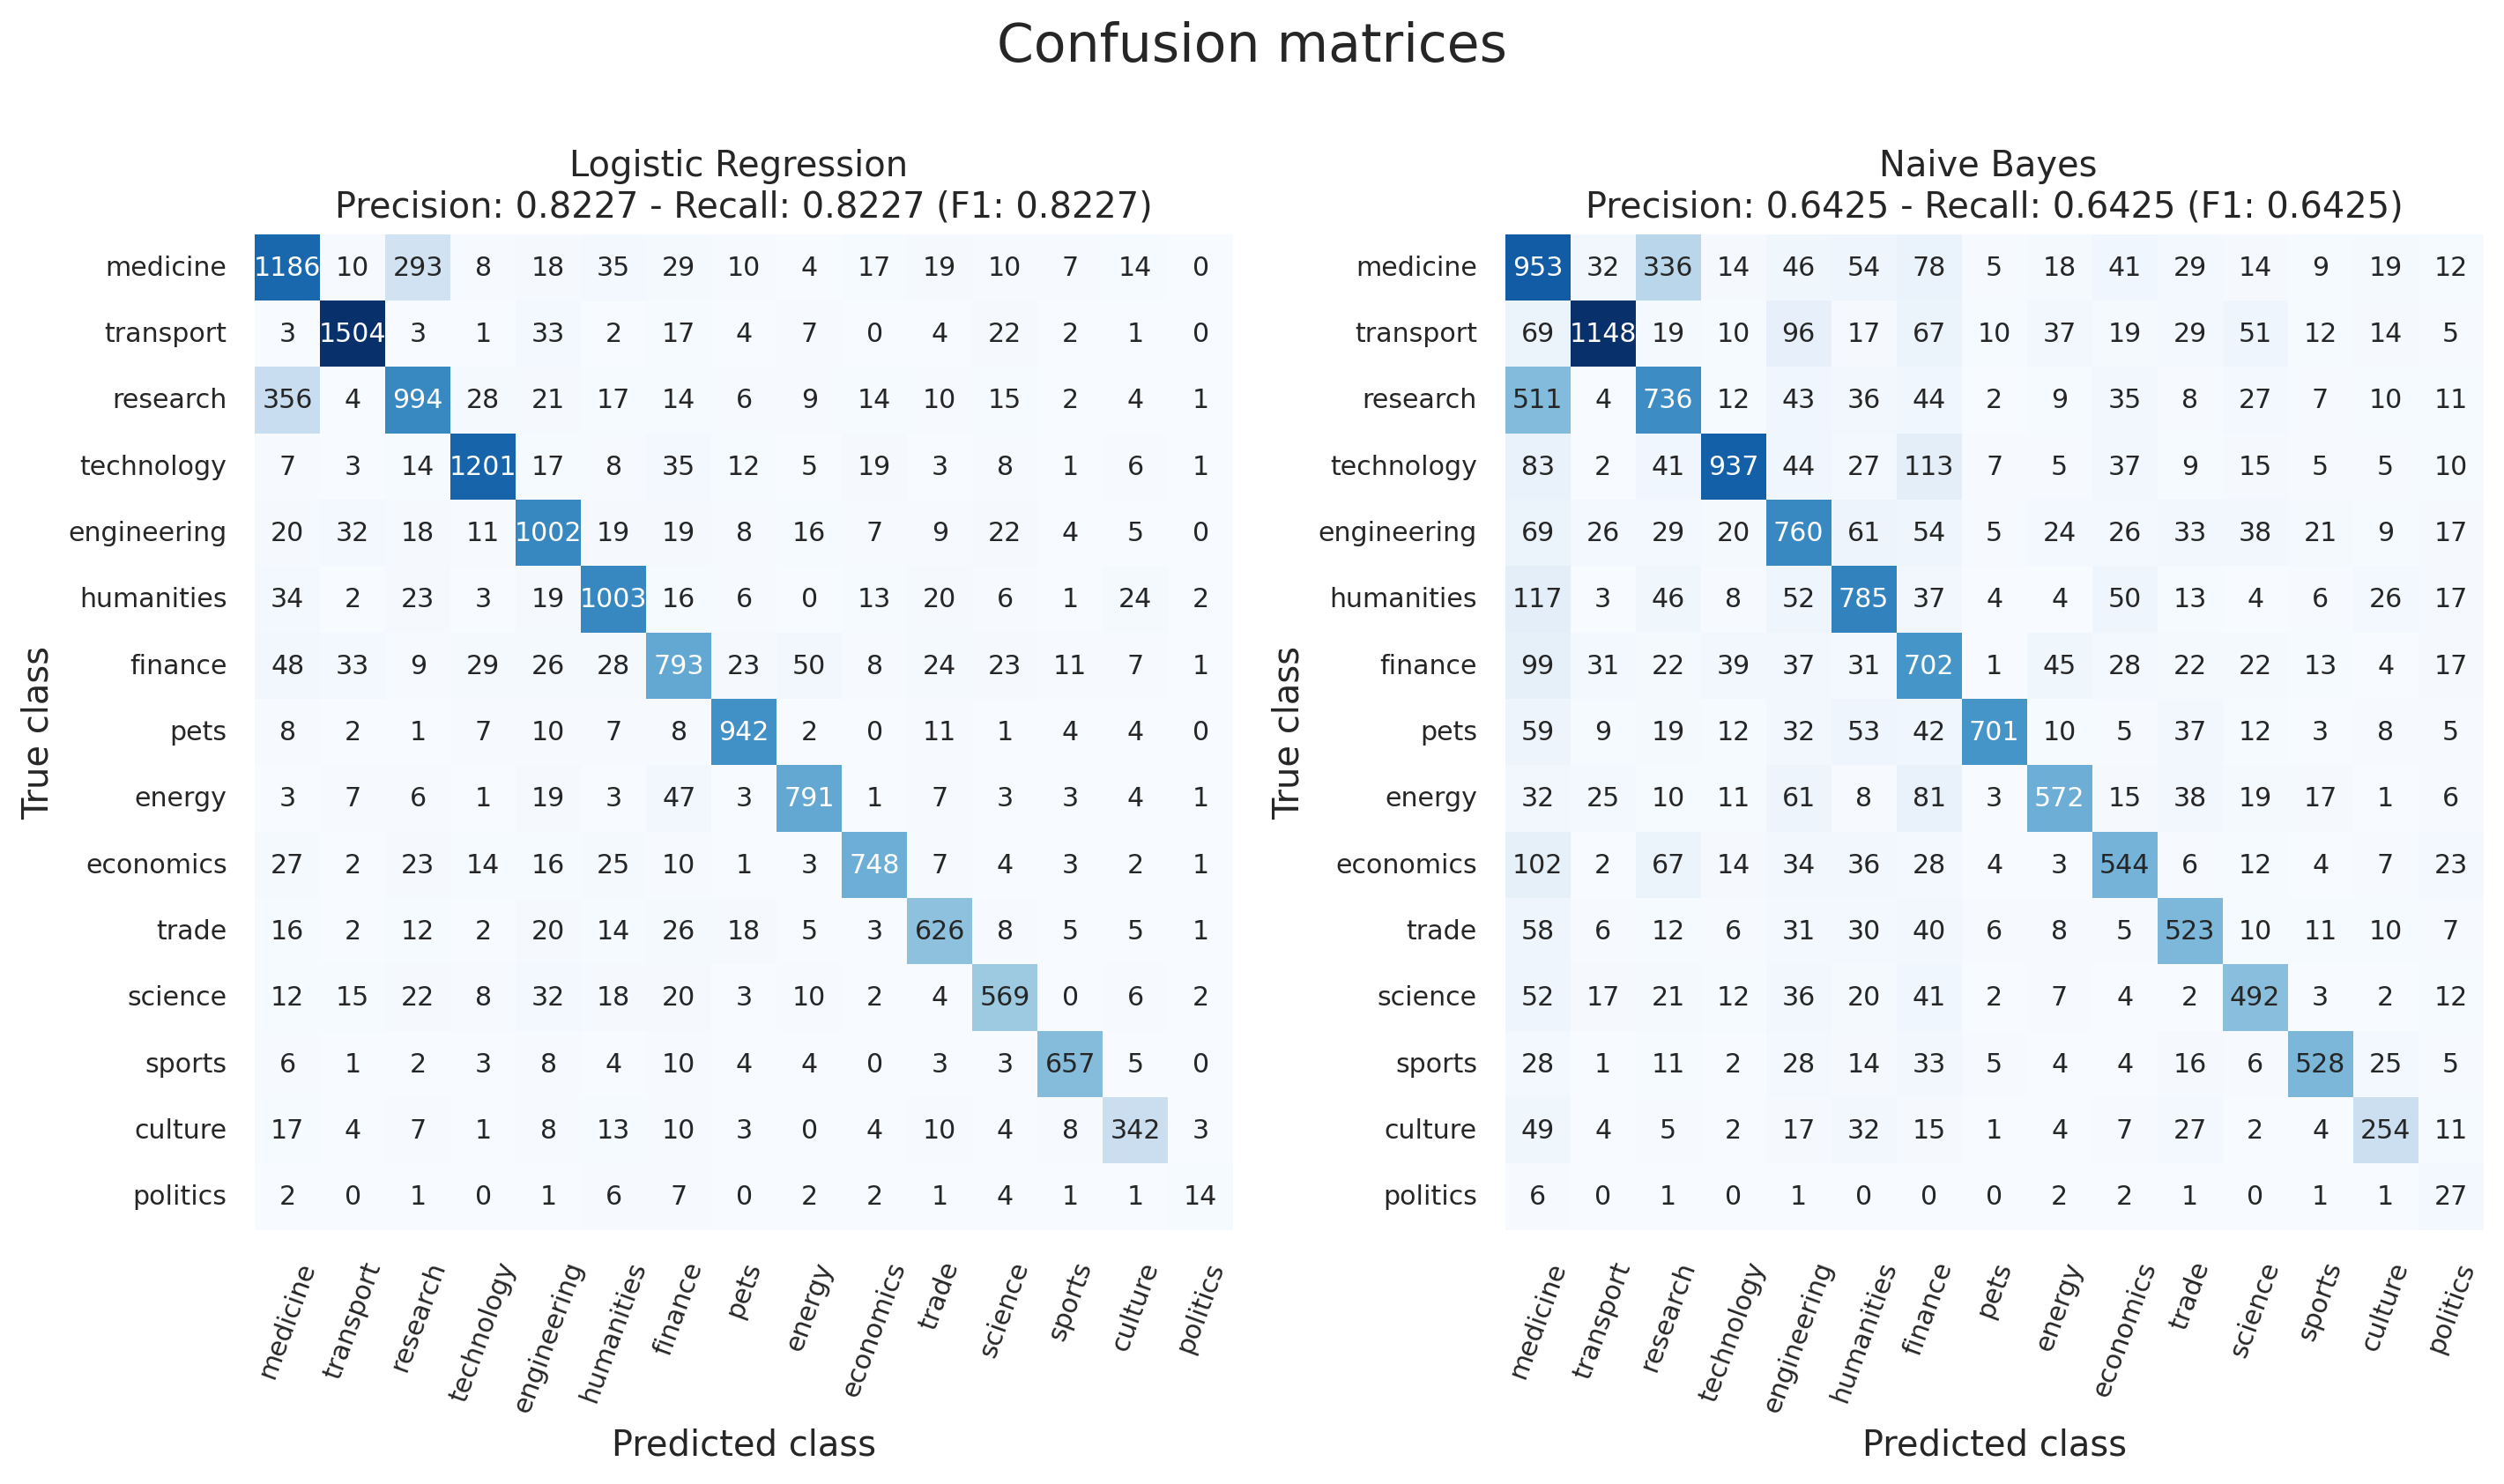

In [ ]:
# Plot confusion matrices from model results
plt.figure(figsize=(12, 7))

for i, (name, results) in enumerate(all_results.items()):
  cm = confusion_matrix(results["y_true"], results["y_pred"], labels=list(range(len(label_names))))
  plt.subplot(1, 2, i+1)
  sns.heatmap(cm, annot=True, annot_kws={"fontsize": 9}, fmt='d', cmap='Blues', cbar=False, xticklabels=label_names, yticklabels=label_names)
  plt.title(f"""{name} \nPrecision: {results['micro']['precision'].values[0]:.4f} - Recall: {results['micro']['recall'].values[0]:.4f} (F1: {results['micro']['f1'].values[0]:.4f})""")
  plt.xlabel('Predicted class')
  plt.ylabel('True class')
  plt.xticks(fontsize=9, rotation=70)
  plt.yticks(fontsize=9)

plt.suptitle(f"Confusion matrices", fontsize=18, y=1)
plt.tight_layout()
plt.show()

By observing the summary of metrics and confusion matrices, the Logistic Regression model achieved significantly better classification performances, with precision and recall values of about 0.82, respect to about 0.64 of the Naive Bayes model, considering the global value (micro-average).

However, there are some clear differences in classification performaces among article categories. The best result was achieved by the "transport" category (F1 score of 0.93) with the Logistic Regression model, and by the "pets" category (F1 score of 0.79) with the Naive Bayes model. The worst result was achieved by the "politics" category with both models (F1 score of 0.40 with Logistic Regression and 0.23 with Naive Bayes). This is an expected result, since the "politics" category was less represented by article samples. It can also be noted from the confusion matrices how both models struggled to correctly distinguish articles in the "medicine" and "research" categories.

### ROC curves and Precision-Recall curves

Here, the Receiver Operating Characteristic (ROC) curves, for each category and micro-averaged, are calculated from binarized true labels and probability predictions and visulized. The ROC curves are plots of the false positive rate versus the true positive rate for different classification thresholds values between 0.0 and 1.0.

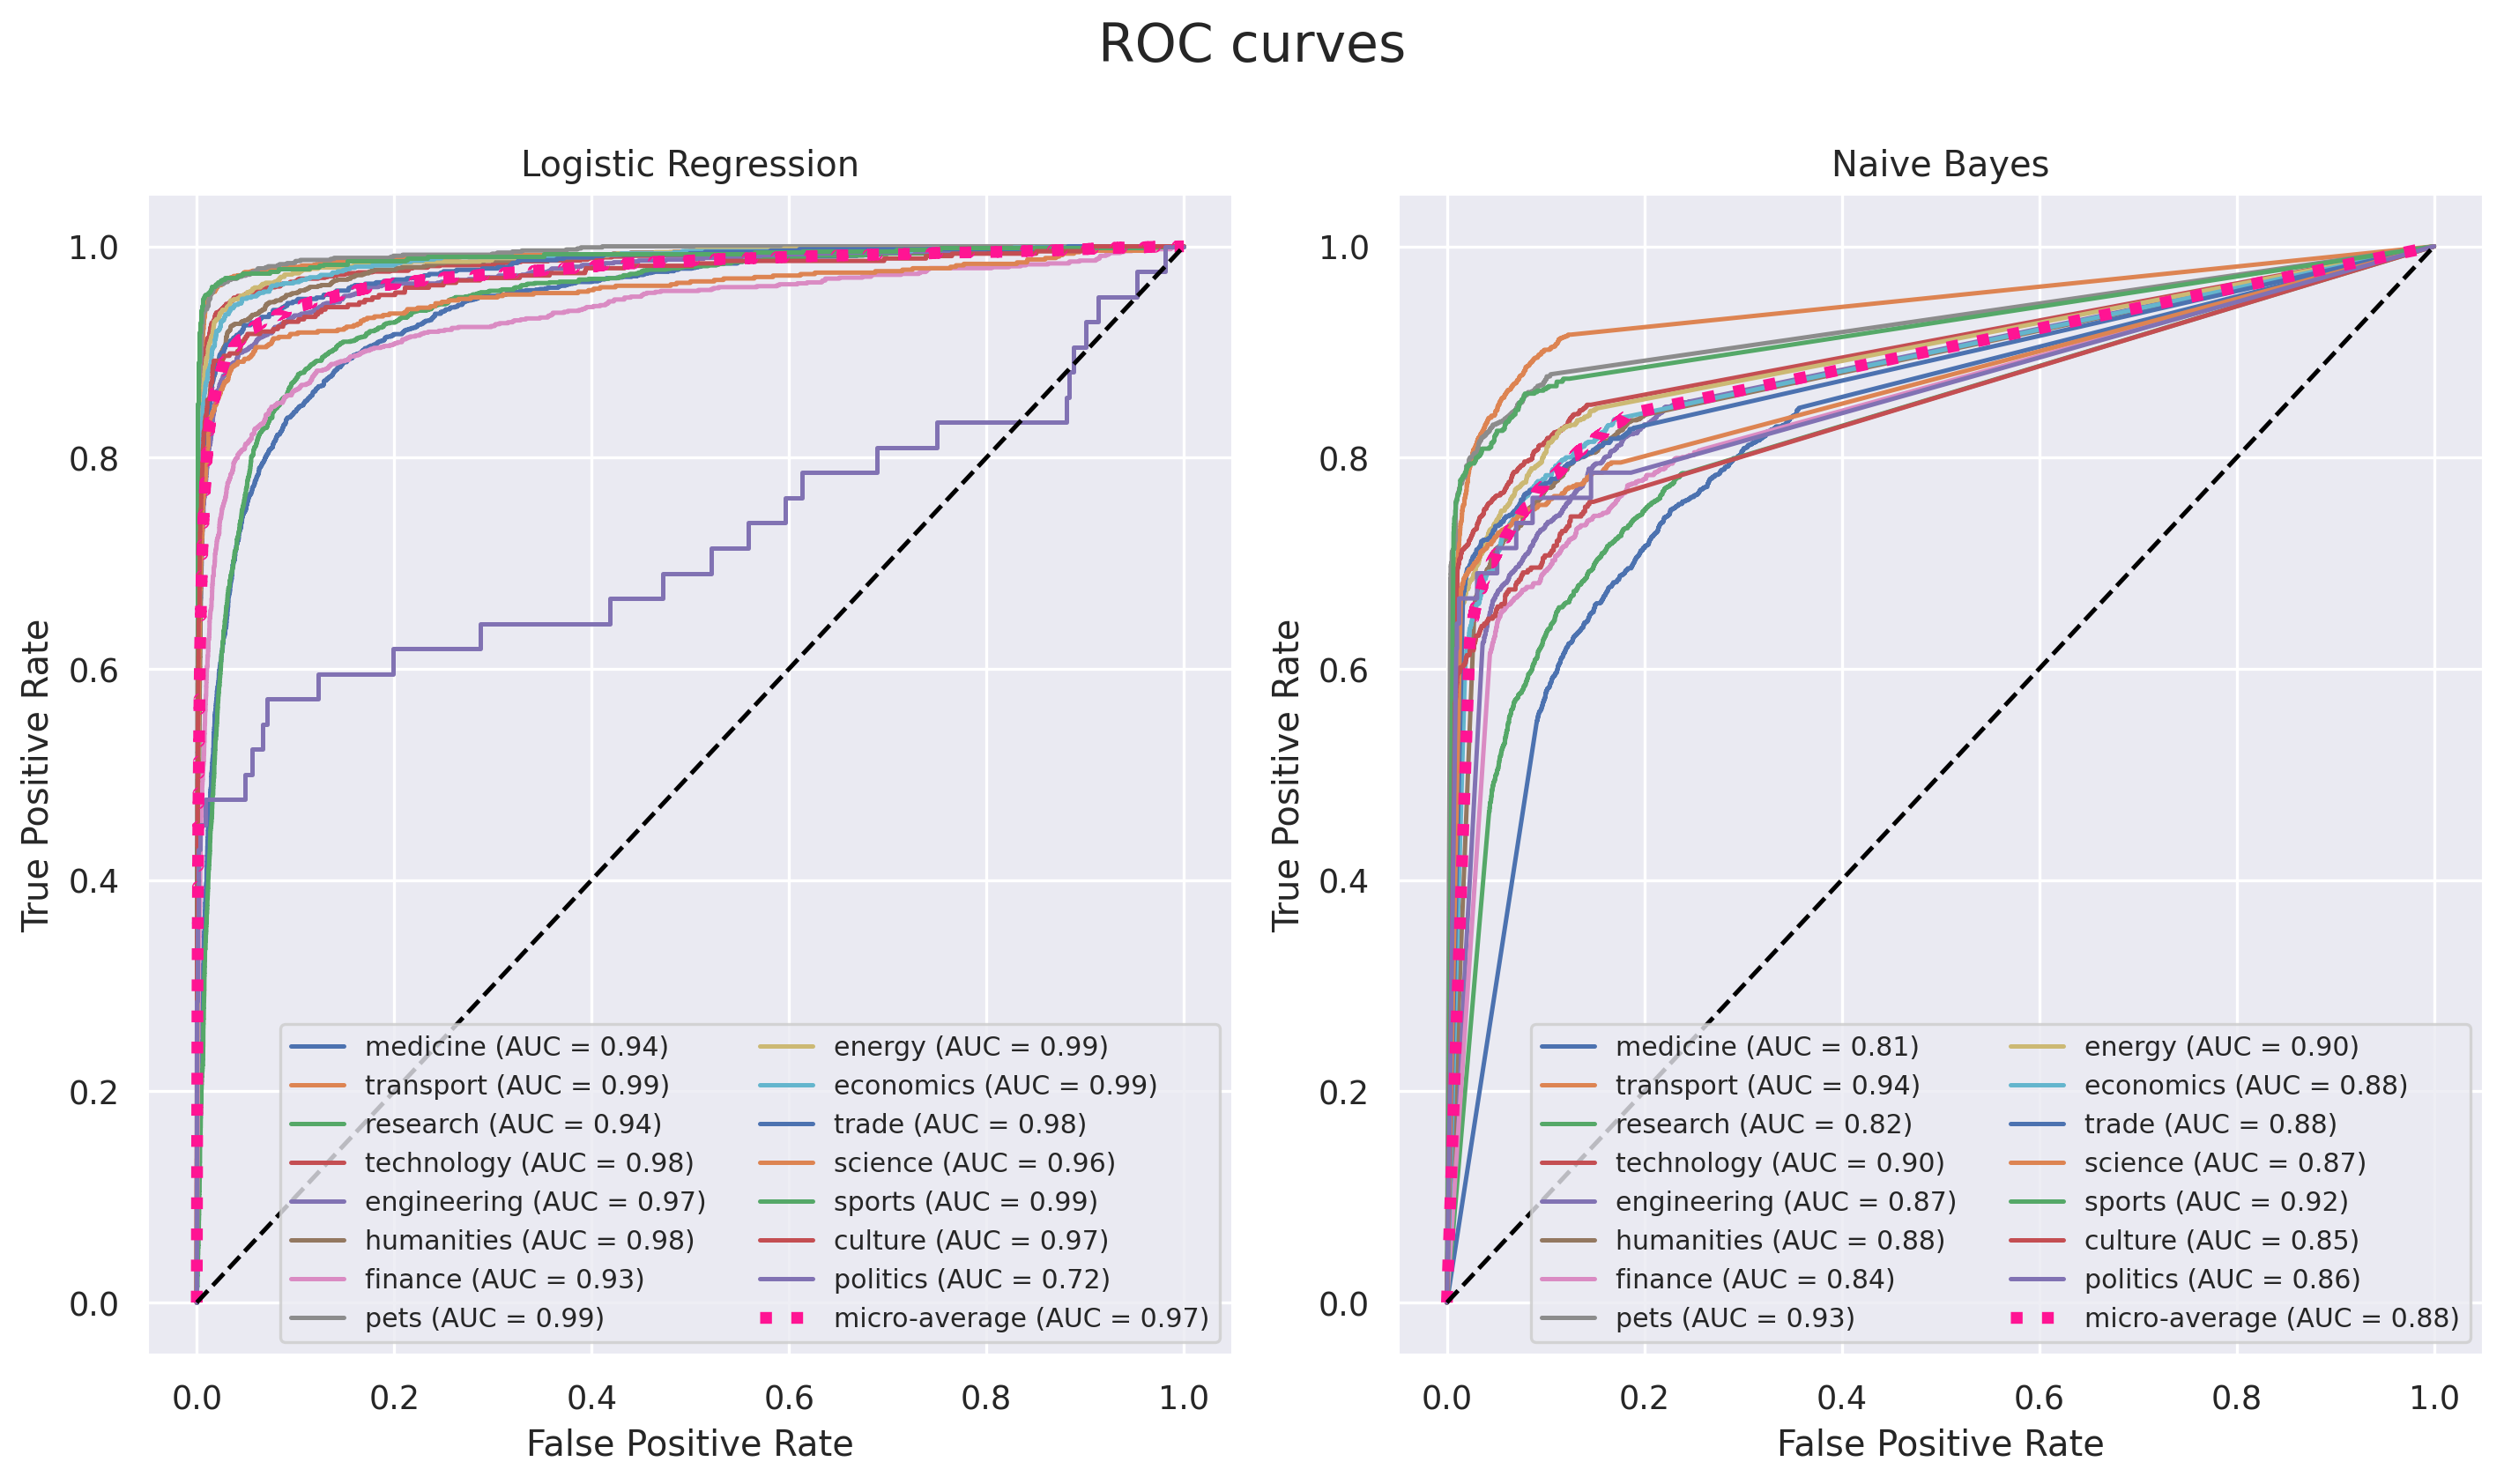

In [ ]:
# Plot multiclass ROC curves from model results
plt.figure(figsize=(12, 7))

for i, (name, results) in enumerate(all_results.items()):
  plt.subplot(1, 2, i+1)
  n_classes = results['y_score'].shape[1]
  for k in range(n_classes):
    true_k = results['y_true_bin'][:, k]
    score_k = results['y_score'][:, k]
    fpr, tpr, _ = roc_curve(true_k, score_k)
    plt.plot(fpr, tpr, label=f"{label_names[k]} (AUC = {results['summary'].loc[k, 'roc_auc']:0.2f})")
  fpr_micro, tpr_micro, _ = roc_curve(results['y_true_bin'].ravel(), results['y_score'].ravel())
  plt.plot(fpr_micro, tpr_micro, linewidth=4, label=f"micro-average (AUC = {results['micro']['roc_auc'].values[0]:0.2f})", color='deeppink', linestyle=':')
  plt.plot([0, 1], [0, 1], color='black', linestyle='--')
  plt.title(f"{name}")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.legend(loc="lower right", fontsize=9, ncol=2)
  plt.grid(True)

plt.suptitle(f"ROC curves", fontsize=18, y=1)
plt.tight_layout()
plt.show()

The plots show how the Logistic Regression model, excluding the "politics" category, resulted in higher areas under the curves (AUC), representing a summary of the model skills, with values between 0.93 and 0.99 (with a micro-average of 0.97). The Naive Bayes models resulted in lower AUC values, ranging between 0.84 and 0.94 (with a micro-average of 0.88).

However, as the datasets are not perfectly balanced, the Precision-Recall curves, which plot the precision and the recall values for different classification thresholds, represent a more accurate visualization of the classification performances, by evaluating the fraction of true positives among positive predictions.

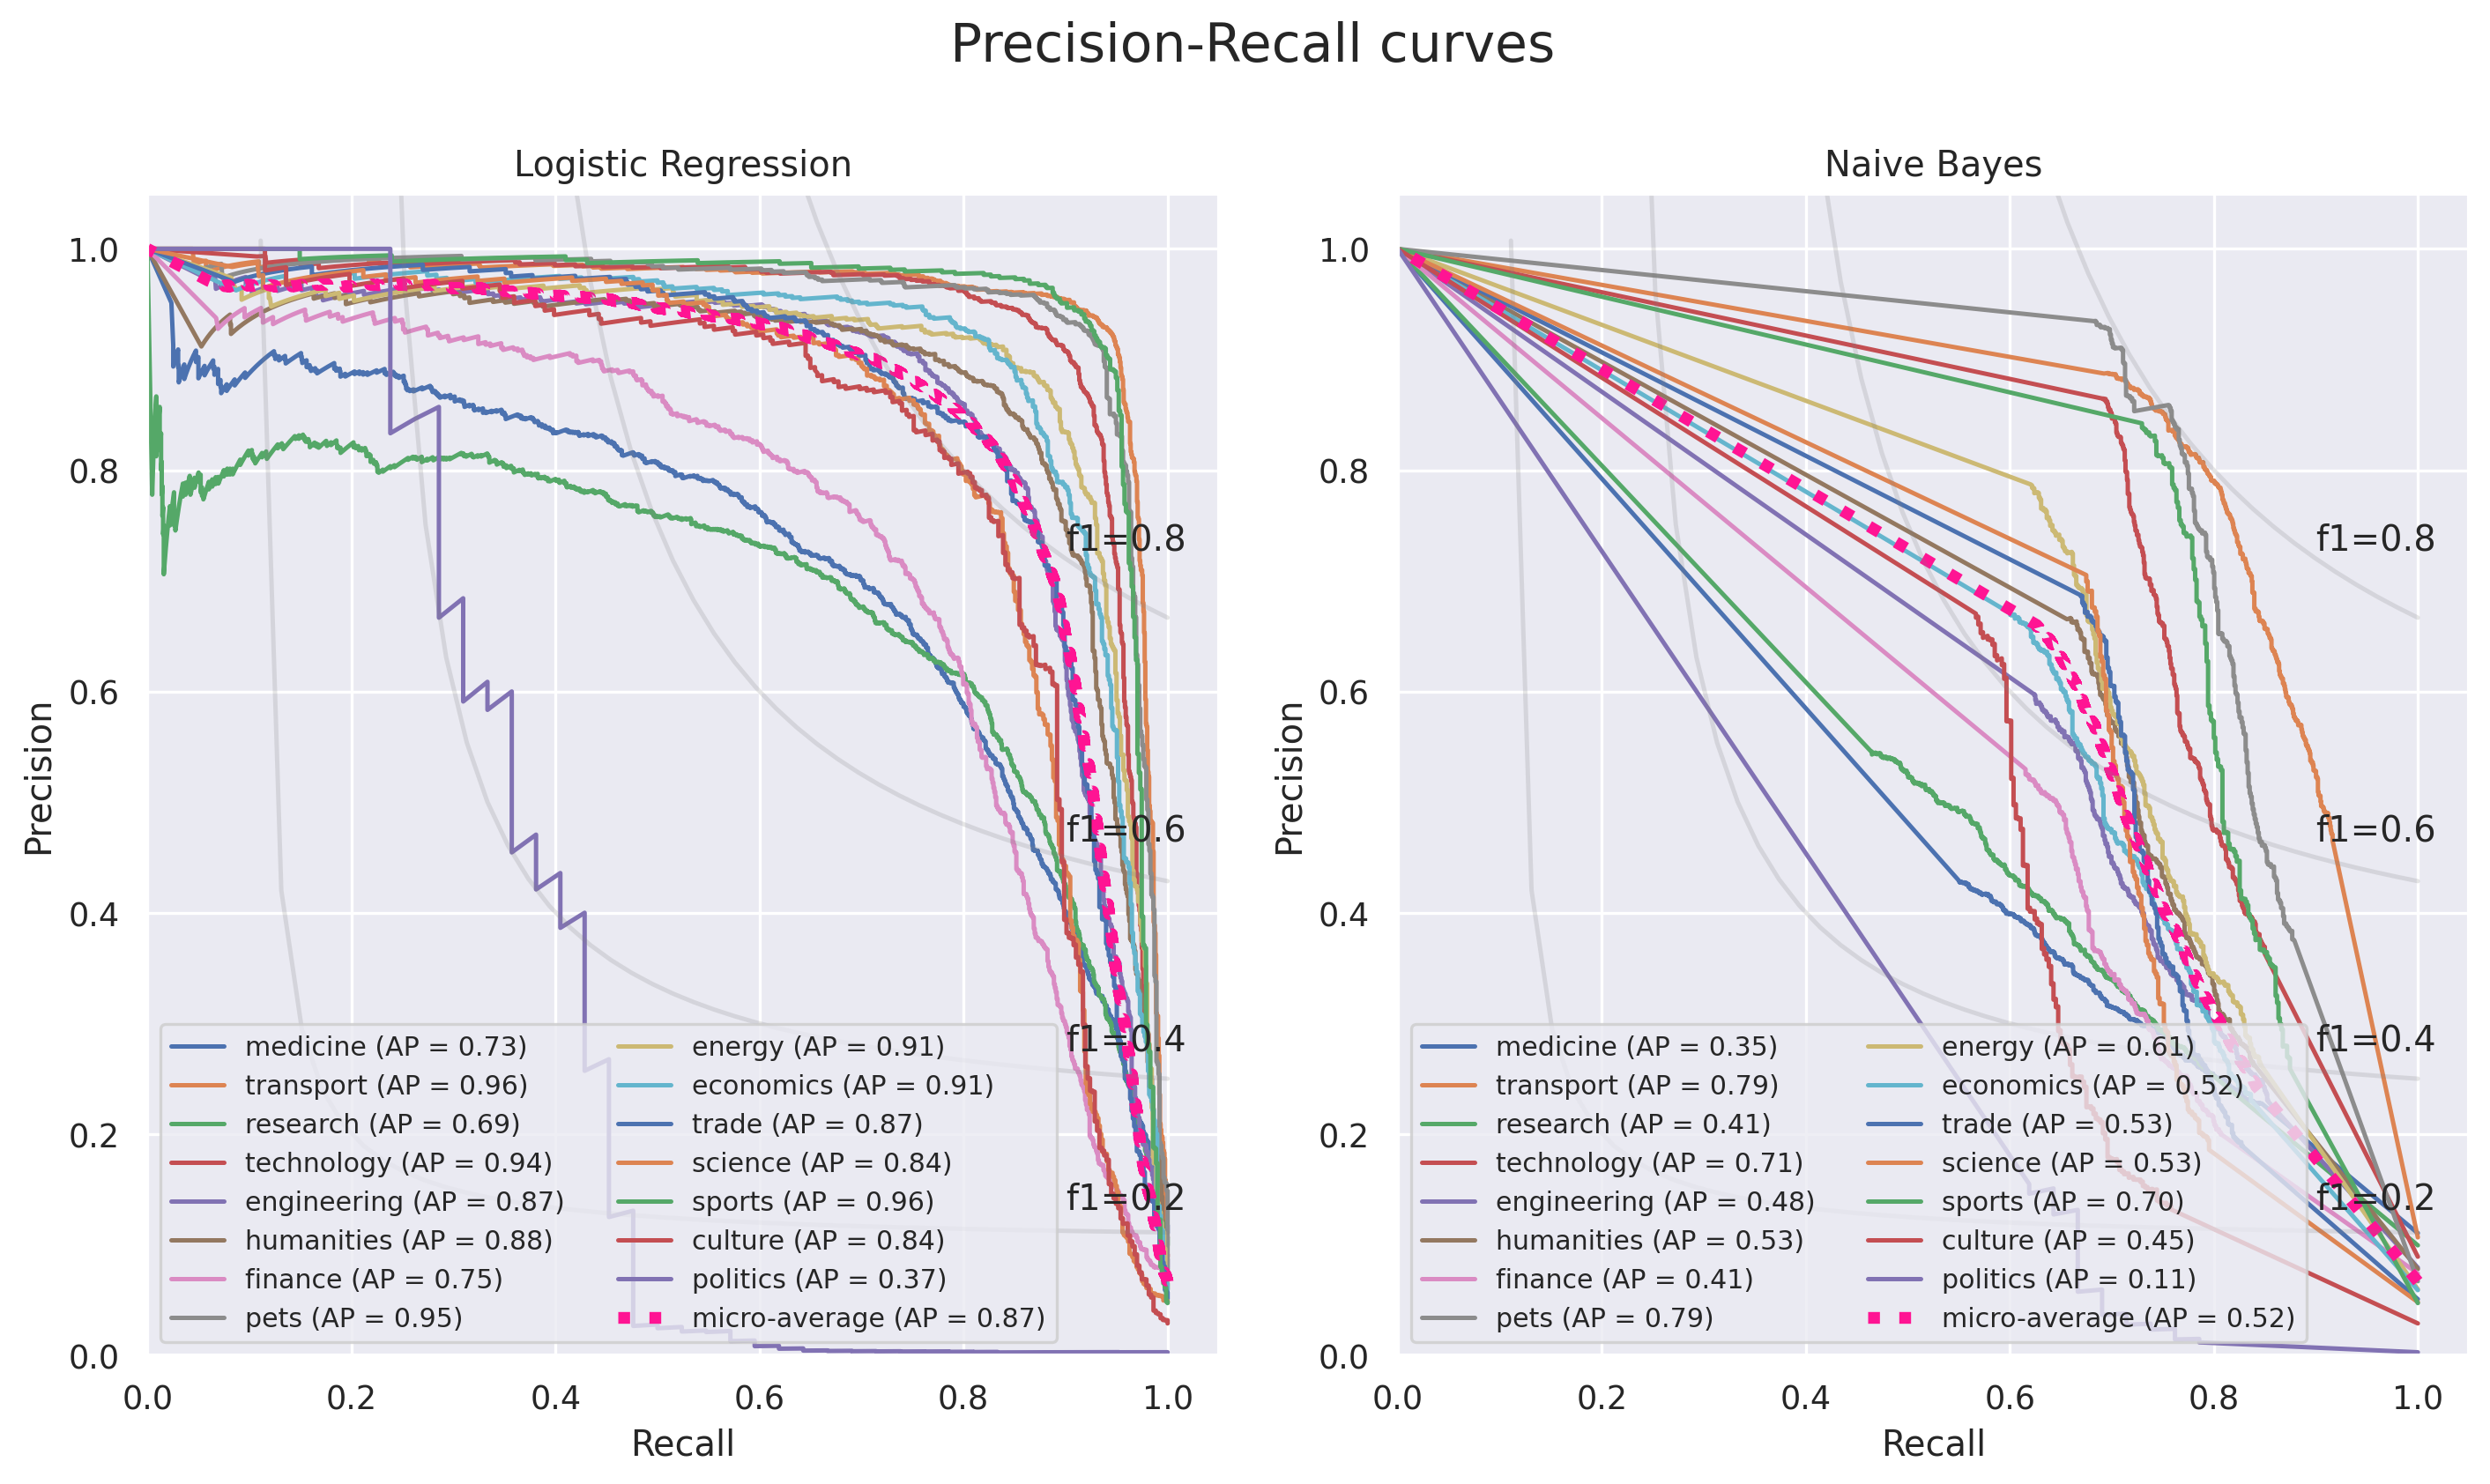

In [ ]:
# Plot multiclass Precision-Recall curves from model results
plt.figure(figsize=(12, 7))

for i, (name, results) in enumerate(all_results.items()):
  plt.subplot(1, 2, i+1)
  n_classes = results['y_score'].shape[1]
  for k in range(n_classes):
    true_k = results['y_true_bin'][:, k]
    score_k = results['y_score'][:, k]
    precision, recall, _ = precision_recall_curve(true_k, score_k)
    plt.plot(recall, precision, label=f"{label_names[k]} (AP = {results['summary'].loc[k, 'avg_precision']:0.2f})")
  precision_micro, recall_micro, _ = precision_recall_curve(results['y_true_bin'].ravel(), results['y_score'].ravel())
  plt.plot(recall_micro, precision_micro, linewidth=4, label=f"micro-average (AP = {results['micro']['avg_precision'].values[0]:0.2f})", color='deeppink', linestyle=':')

  f_scores = np.linspace(0.2, 0.8, num=4)
  for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate(f"f1={f_score:0.1f}", xy=(0.9, y[45] + 0.02))

  plt.xlim([0.0, 1.05])
  plt.ylim([0.0, 1.05])
  plt.title(f"{name}")
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.legend(loc="lower left", fontsize=9, ncol=2)
  plt.grid(True)

plt.suptitle(f"Precision-Recall curves", fontsize=18, y=1)
plt.tight_layout()
plt.show()

It the case of Precision-Recall curves, the AUC values, represented by the Average Precision (AP), are lower and more variable respect to the ROC curves, with micro-average values of 0.87 for Logistic Regression and 0.52 for Naive Bayes. Here it can clearly be observed the higher performances for the "transport", "sports" and "pets" categories respect to "medicine", "research" and, particularly, "politics" categories.